# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.

## Exploración de datos y medición de $k$

In [1]:
#!pip install Numpy
#!pip install Pandas
#!pip install matplotlib
#!pip install scipy
#!pip install Pillow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import seaborn as sns
sns.set()
#from jupyterthemes import jtplot
import os
from scipy.optimize import curve_fit
from datetime import datetime
from datetime import date, timedelta

#from google.colab import drive
#from scipy.optimize import curve_fit

# Estilo del gráfico segun el thema
#jtplot.style(#'chesterish'
             #'grade3'
             #'gruvboxd'
             #'gruvboxl'
             #'monokai'
             #'oceans16'
             #'onedork'
#             'solarizedd'
             #'solarizedl'
#            )

### a. Explorar la fuente de datos:

 * ¿ Qué representa el dataset?
 * ¿ Hay información sobre las columnas?

In [3]:
os.listdir('data')

['contagios_covid_data.csv', 'owid-covid-data.csv']

In [4]:
datos=pd.read_csv('data/contagios_covid_data.csv')
datos

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165403,ZWE,Africa,Zimbabwe,2022-02-25,235467.0,500.0,348.143,5392.0,2.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
165404,ZWE,Africa,Zimbabwe,2022-02-26,235803.0,336.0,368.429,5393.0,1.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
165405,ZWE,Africa,Zimbabwe,2022-02-27,235803.0,0.0,350.143,5393.0,0.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
165406,ZWE,Africa,Zimbabwe,2022-02-28,236380.0,577.0,401.286,5395.0,2.0,1.286,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [5]:
# Pasamos columna date a formato de fecha
#df['date'] = df['date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
datos['date']= pd.to_datetime(datos['date']) 
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165408 entries, 0 to 165407
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    165408 non-null  object        
 1   continent                                   155504 non-null  object        
 2   location                                    165408 non-null  object        
 3   date                                        165408 non-null  datetime64[ns]
 4   total_cases                                 162378 non-null  float64       
 5   new_cases                                   162230 non-null  float64       
 6   new_cases_smoothed                          160247 non-null  float64       
 7   total_deaths                                144574 non-null  float64       
 8   new_deaths                                  144611 non-null  float64      

### b. Análisis exploratorio

#### 10 Países
 Los paises seleccionados son:
 * **Argentina**
 * **Colombia**
 * **Brazil**
 * **United States**
 * **China**
 * **Kazakhstan**
 * **Russia**
 * **Japan**
 * **Italy**
 * **Egypt**
 * **South Africa**
 * **Spain**

In [6]:
paises=datos['location'] #cargo el vector de paises
confirmados=datos['total_cases'] #carga vector todos los casos confirmados

Text(0.5, 0.98, 'Casos Totales')

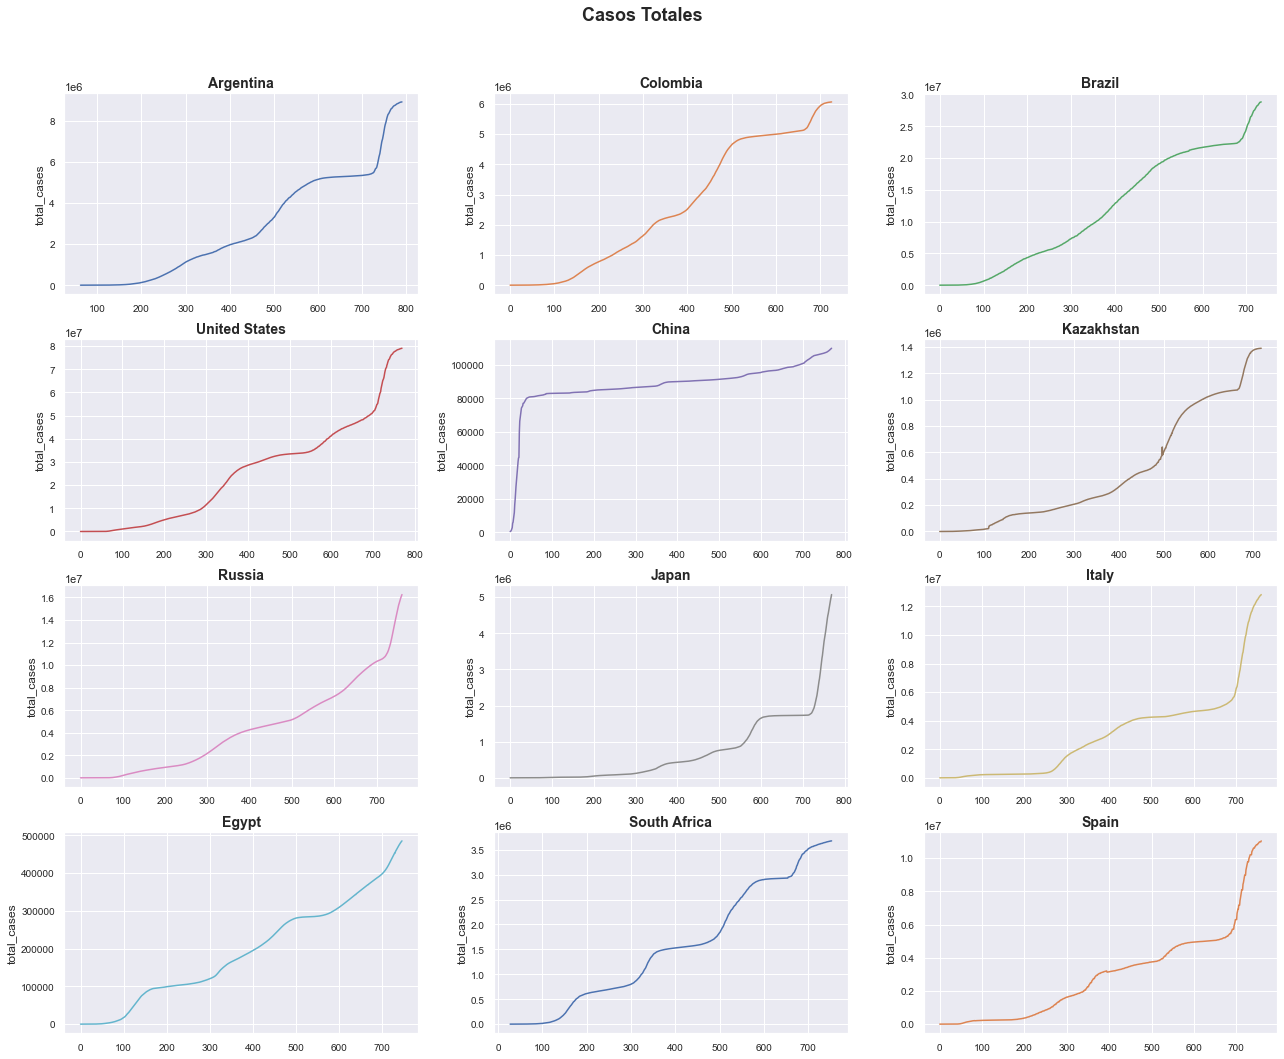

In [7]:
# Mostramos el comprtamiento para los países seleccionados
#sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 15))
axes = axes.flat

Paises = ['Argentina','Colombia','Brazil','United States',
          'China',
          'Kazakhstan',
          'Russia',
          'Japan',
          'Italy',
          'Egypt',
          'South Africa',
          'Spain'
          #,'India'
         ]

for j,p in enumerate(Paises):
    ind_arg=np.where(paises==p) #indises de pais de interes
    ind_arg=ind_arg[0]
    casos_arg=confirmados[ind_arg]
    dias=np.arange(0,len(casos_arg))
    #plt.figure(figsize = (15,8))
    #plt.plot(dias,casos_arg)
    #plt.xlabel('dias')
    #plt.ylabel('cantidad de casos')
    sns.lineplot(x=dias, y=casos_arg,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #markers=True,
        #dashes=True,
        #legend="full",
        alpha   = 1.0, ax = axes[j])
    axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
    axes[j].tick_params(labelsize = 10)
    axes[j].tick_params(labelsize = 10)
    axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Casos Totales', fontsize = 18, fontweight = "bold")

Estas son las curvas de **casos totales**. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Estas hablan de los acumulados, entonces siempre se agregan.

Para ver mejor las curvas, podemos tomar el logartimo de los datos. **Una curva exponencial se ve lineal en escala logarítmica**


Text(0.5, 0.98, 'log cantidad de casos')

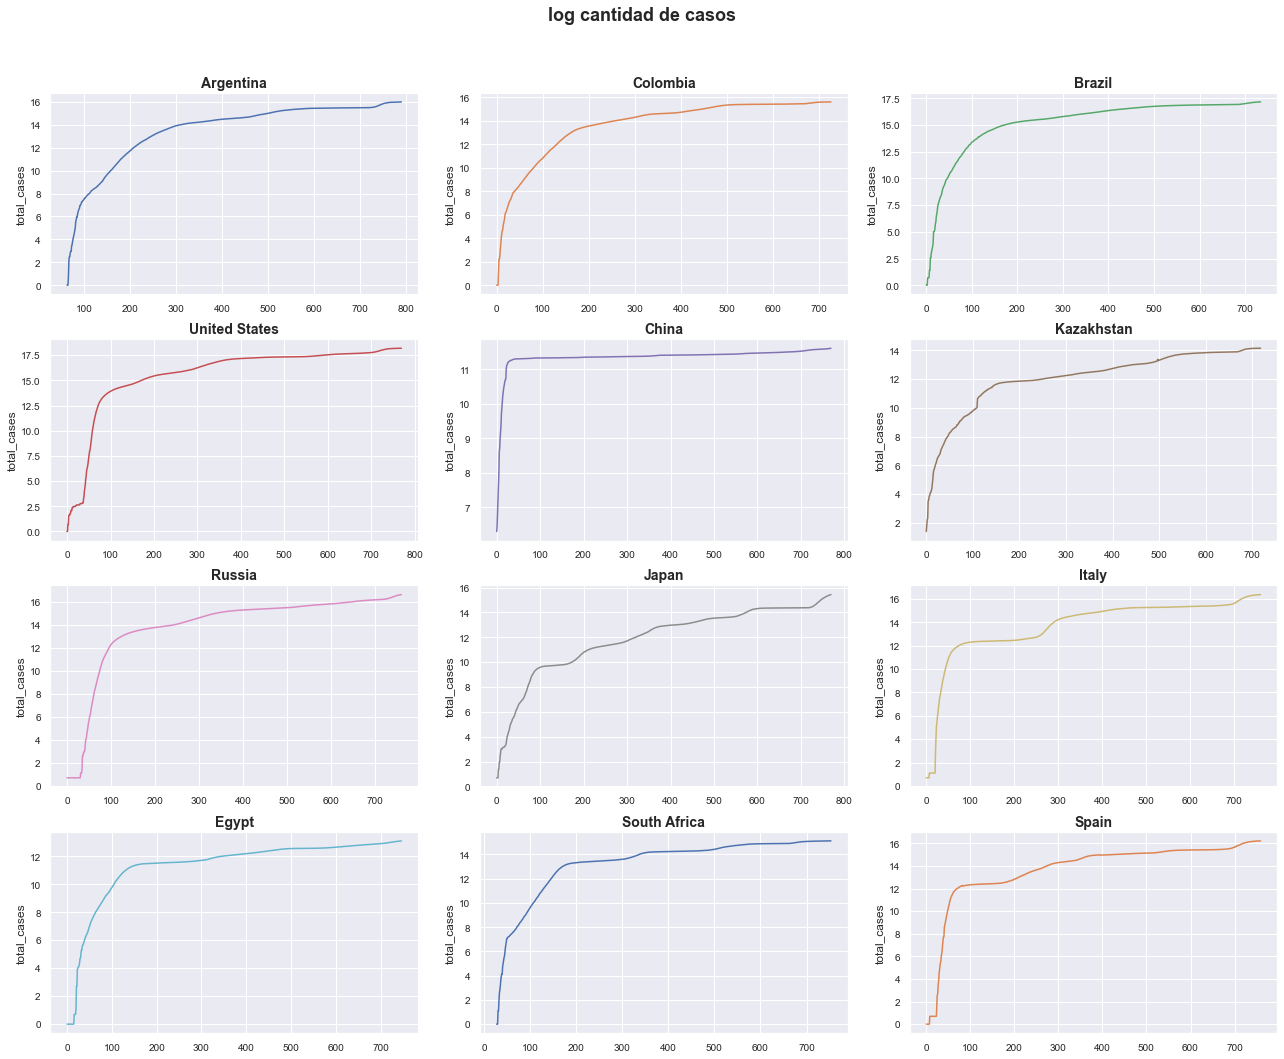

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 15))
axes = axes.flat

for j,p in enumerate(Paises):
    ind_arg=np.where(paises==p)
    ind_arg=ind_arg[0]
    casos_arg=confirmados[ind_arg]
    dias=np.arange(0,len(casos_arg))
    #plt.figure(figsize = (15,8))
    #plt.plot(dias,casos_arg)
    #plt.xlabel('dias')
    #plt.ylabel('cantidad de casos')
    sns.lineplot(x=dias, y=np.log(casos_arg),
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[j])
    axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
    axes[j].tick_params(labelsize = 10)
    axes[j].tick_params(labelsize = 10)
    axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('log cantidad de casos', fontsize = 18, fontweight = "bold")

#### Etapa inicial del crecimiento
 Veamos lo que pasa en los **primeros 60 días** desde que se detectó el primer caso en cada país, para ver cómo fue el 𝑘 inicial

In [9]:
# Identificamos los paises en los que el registro del primer caso ocurre despues de los registros iniciales
Paises = ['Argentina','Colombia','Brazil','United States',
          'China',
          'Kazakhstan',
          'Russia',
          'Japan',
          'Italy',
          'Egypt',
          'South Africa',
          'Spain',
          'World'
          #,'India'
         ]
for j,p in enumerate(Paises):
    df = datos[datos.location == p]
    print(f'{j+1}. {p}:',df.total_cases.isnull().idxmin()-df.iloc[0].name)

1. Argentina: 62
2. Colombia: 0
3. Brazil: 0
4. United States: 0
5. China: 0
6. Kazakhstan: 0
7. Russia: 0
8. Japan: 0
9. Italy: 0
10. Egypt: 0
11. South Africa: 27
12. Spain: 0
13. World: 0


De estos paises argentina y South Africa presenta un desface de 62 y 27 dias en el reporte del primer caso espectivamente.

Text(0.5, 0.98, 'Cantidad de casos primeros 60 días')

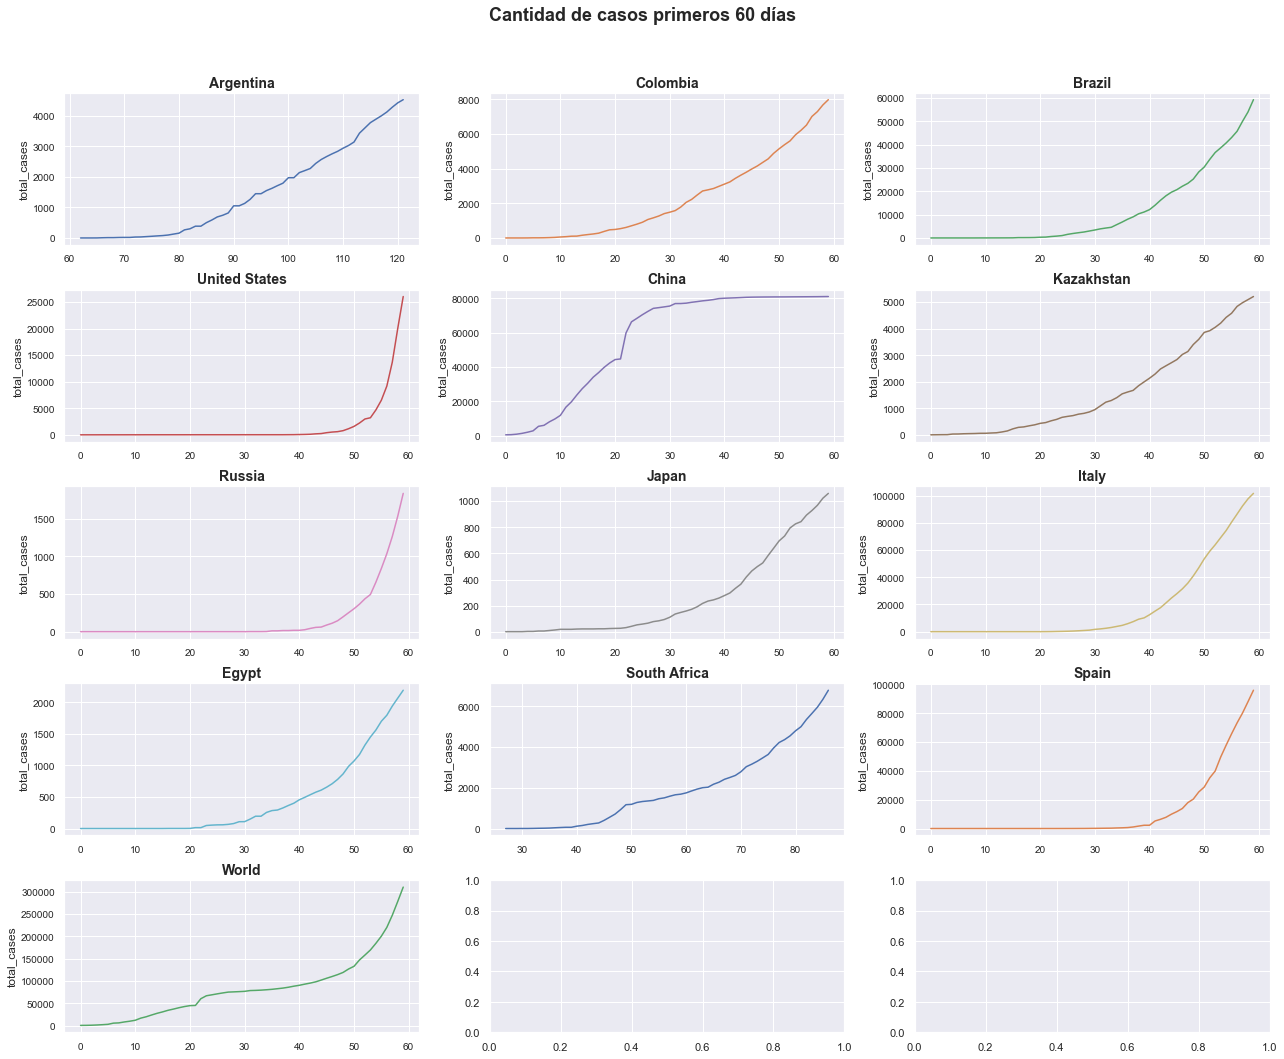

In [10]:
#primeros 60 días

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 15))
axes = axes.flat

for j,p in enumerate(Paises):
    ind_p=np.where(paises==p)
    ind_p=ind_p[0]
    casos_p=confirmados[ind_p]
    dias=np.arange(0,len(casos_p))
    
    df = datos[datos.location == p]
    l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
    casos_principio=casos_p[l_i:l_i+60]
    dias_principio=dias[l_i:l_i+60]
    
    sns.lineplot(x=dias_principio, y=casos_principio,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[j])
    axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
    axes[j].tick_params(labelsize = 10)
    axes[j].tick_params(labelsize = 10)
    axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Cantidad de casos primeros 60 días', fontsize = 18, fontweight = "bold")

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica, ya que el comportamiento exponencial pasa a ser lineal.

Text(0.5, 0.98, 'log cantidad de casos primeros 60 días')

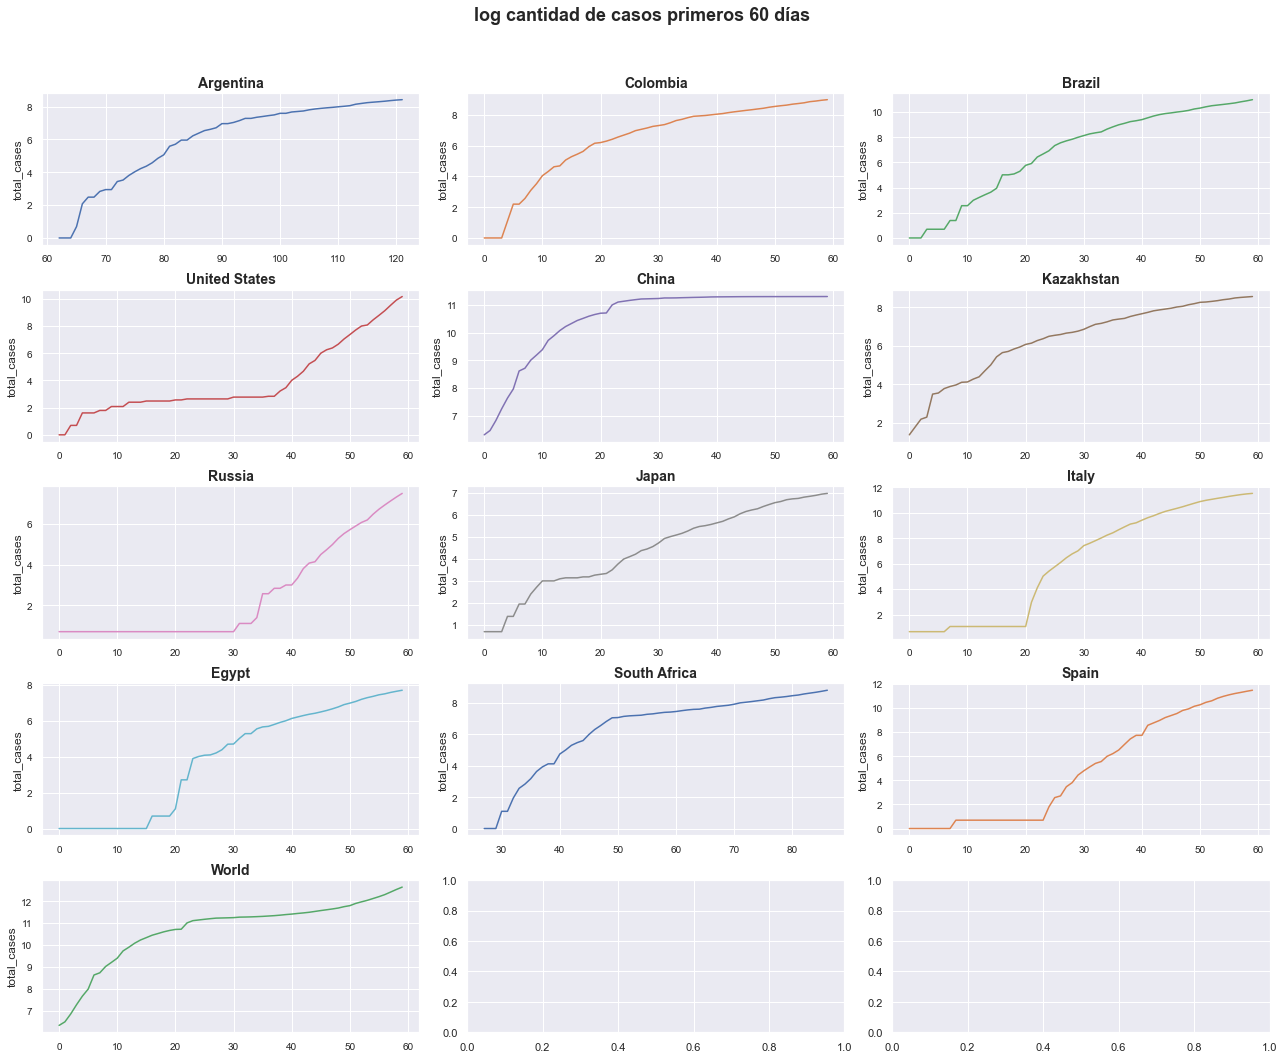

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 15))
axes = axes.flat

for j,p in enumerate(Paises):
    ind_arg=np.where(paises==p)
    ind_arg=ind_arg[0]
    casos_arg=confirmados[ind_arg]
    dias=np.arange(0,len(casos_arg))
    
    df = datos[datos.location == p]
    l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
    casos_principio=casos_arg[l_i:l_i+60]
    dias_principio=dias[l_i:l_i+60]
    
    sns.lineplot(x=dias_principio, y=np.log(casos_principio),
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[j])
    axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
    axes[j].tick_params(labelsize = 10)
    axes[j].tick_params(labelsize = 10)
    axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('log cantidad de casos primeros 60 días', fontsize = 18, fontweight = "bold")

Seleccionamos rangos específicos de días para cada país, en los que se muestra un comportamiento más sostenido.

In [12]:
# Limites

limites_i = [66,36,44,37,0,17,45,32,30,36,49,29,45]
limites_s = [90,60,60,60,15,60,60,52,50,60,60,39,60]

df_parametros = pd.DataFrame({'Pais': Paises, 't0': limites_i, 'tf':limites_s})
df_parametros

,Pais,t0,tf
0,Argentina,66,90
1,Colombia,36,60
2,Brazil,44,60
3,United States,37,60
4,China,0,15
5,Kazakhstan,17,60
6,Russia,45,60
7,Japan,32,52
8,Italy,30,50
9,Egypt,36,60


Text(0.5, 0.98, 'log cantidad de casos primeros 60 días')

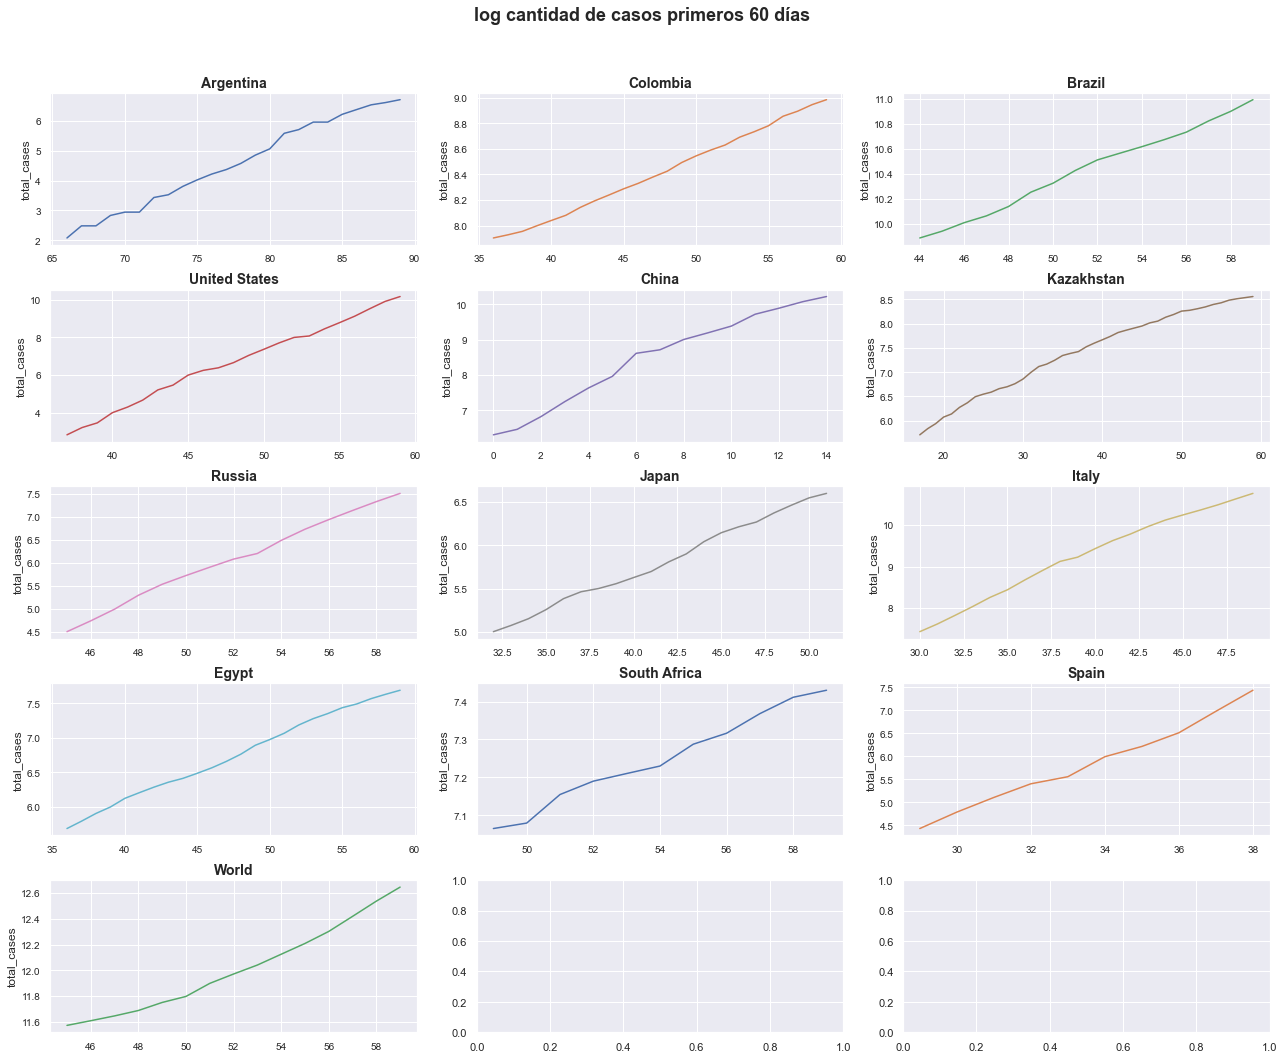

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 15))
axes = axes.flat

for j,p in enumerate(Paises):
    ind_arg=np.where(paises==p)
    ind_arg=ind_arg[0]
    casos_arg=confirmados[ind_arg]
    dias=np.arange(0,len(casos_arg))
    
    #df = datos[datos.location == p]
    #l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
    casos_principio=casos_arg[limites_i[j]:limites_s[j]]
    dias_principio=dias[limites_i[j]:limites_s[j]]
    
    sns.lineplot(x=dias_principio, y=np.log(casos_principio),
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[j])
    axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
    axes[j].tick_params(labelsize = 10)
    axes[j].tick_params(labelsize = 10)
    axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('log cantidad de casos primeros 60 días', fontsize = 18, fontweight = "bold")

En general vemos una linealidad. Aprovechemos esto para averiguar el $k$ utilizando un ajuste hecho con el método de cuadrados mínimos, ajustando los datos al modelo 

$Confirmados=e^{k(t-t_0)}$



#### Extracción del  $k$

In [14]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [15]:
t_0 = []
k = []
for j,p in enumerate(Paises):
    ind_p =np.where(paises==p)
    ind_p=ind_p[0]
    casos_p=confirmados[ind_p]
    dias=np.arange(0,len(casos_p))
    
    #df = datos[datos.location == p]
    #l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
    casos_principio=casos_arg[limites_i[j]:limites_s[j]]
    dias_principio=dias[limites_i[j]:limites_s[j]]
    
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
    
    t_0.append(popt[1])
    k.append(popt[0])
df_parametros['k´s'] = k
#df_parametros = pd.DataFrame({'Pais': Paises, 'k´s': k, 't_0´s':t_0})
df_parametros
    #print(p,'---->',f'k = {popt[0]},',f't_0 = {popt[1]}')
    #print('--------------------------------------------------------------------')

,Pais,t0,tf,k´s
0,Argentina,66,90,0.050696
1,Colombia,36,60,0.067510
2,Brazil,44,60,0.082312
3,United States,37,60,0.069119
4,China,0,15,0.220378
5,Kazakhstan,17,60,0.049051
6,Russia,45,60,0.084539
7,Japan,32,52,0.033192
8,Italy,30,50,0.026840
9,Egypt,36,60,0.067510


Veamos cómo se ajusta lo que obtuvimos a los datos reales

Text(0.5, 0.98, 'log cantidad de casos primeros 60 días')

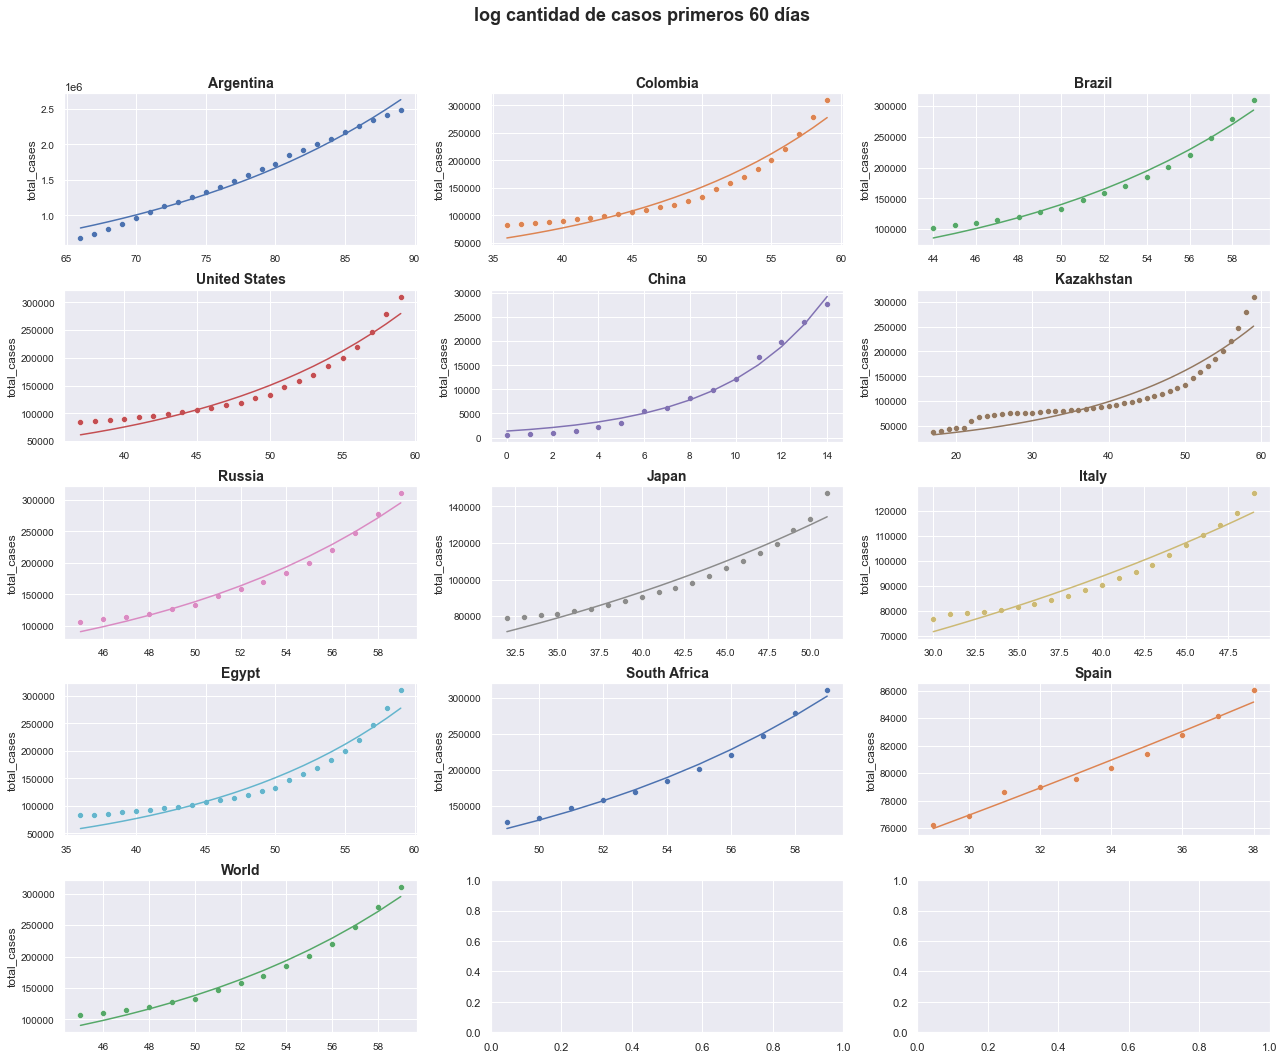

In [16]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 15))
axes = axes.flat

for j,p in enumerate(Paises):
    ind_p=np.where(paises==p)
    ind_p=ind_p[0]
    casos_p=confirmados[ind_p]
    dias=np.arange(0,len(casos_p))
    
    #df = datos[datos.location == p]
    #l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
    casos_principio=casos_arg[limites_i[j]:limites_s[j]]
    dias_principio=dias[limites_i[j]:limites_s[j]]
    
    casos_simu=exponencial(dias_principio,k[j],t_0[j])
    sns.scatterplot(x=dias_principio, y=casos_principio,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[j])
    sns.lineplot(x=dias_principio, y=casos_simu,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[j]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[j])
    axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
    axes[j].tick_params(labelsize = 10)
    axes[j].tick_params(labelsize = 10)
    axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('log cantidad de casos primeros 60 días', fontsize = 18, fontweight = "bold")

In [17]:
df_parametros.iloc[:12].agg(func='mean')

t0     35.083333
tf     55.500000
k´s     0.071461
dtype: float64

#### Intervalo de confianza k's

 Generar un intervalo de confianza para el valor $k$ midiéndolo para varios países, con el objetivo de representar la población mundial con la selección que se haga.

In [18]:
def bootstrap_simplificado(dataset, B=100):
    boots = []
    for _ in range(B):
        boots.append(np.random.choice(dataset, size=len(dataset)))
    return np.array(boots)

k_final=0.0713087445929841


Text(0, 0.5, 'Muestras')

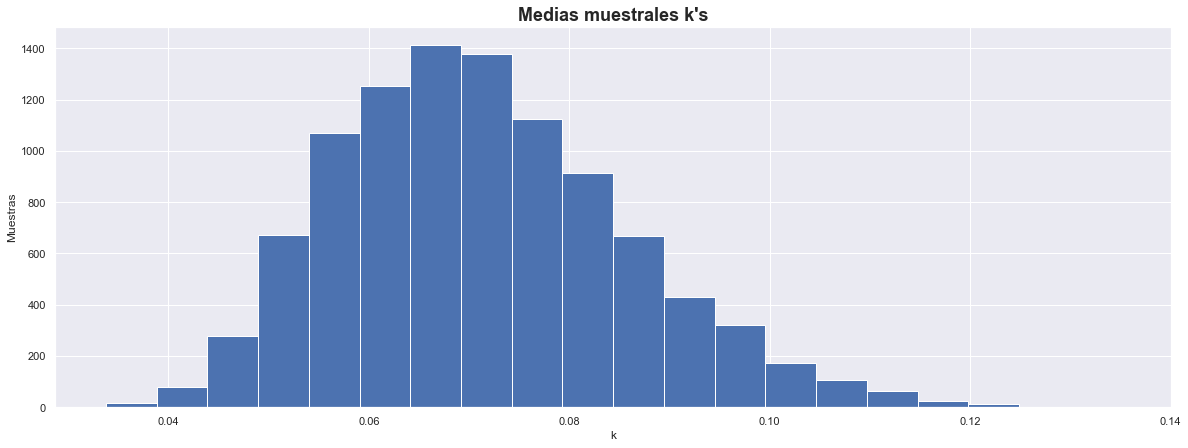

In [19]:
# Bootstrapping

datos_boots = bootstrap_simplificado(df_parametros.iloc[:12]['k´s'],10000)
medias = np.apply_along_axis(func1d=np.mean, axis=1, arr=datos_boots)
medias.sort()
k_final = medias.mean()
print(f"k_final={medias.mean()}")
plt.figure(figsize=(20,7))
plt.title('Medias muestrales k\'s', fontsize = 18, fontweight = "bold")
plt.hist(medias, bins=20)
plt.xlabel("k")
plt.ylabel("Muestras")


In [20]:
# Construccion del intervalo de confianza
alpha = 5
inferior = np.percentile(medias, alpha/2)
superior = np.percentile(medias, (100-alpha/2))
intervalo_confianza = [inferior, superior]
print(f"Con una certeza del 95% el valor del k promedio se encuentra en el intervalo: {intervalo_confianza}")

Con una certeza del 95% el valor del k promedio se encuentra en el intervalo: [0.04716609909651987, 0.10347757520654495]


### c. Criterio de elección
Los países seleccionados fueron elegidos de un entorno cercano de china y otros con una comunicación fuerte con china o países del entrono cercano.

### d. World

Text(0.5, 0, 'días')

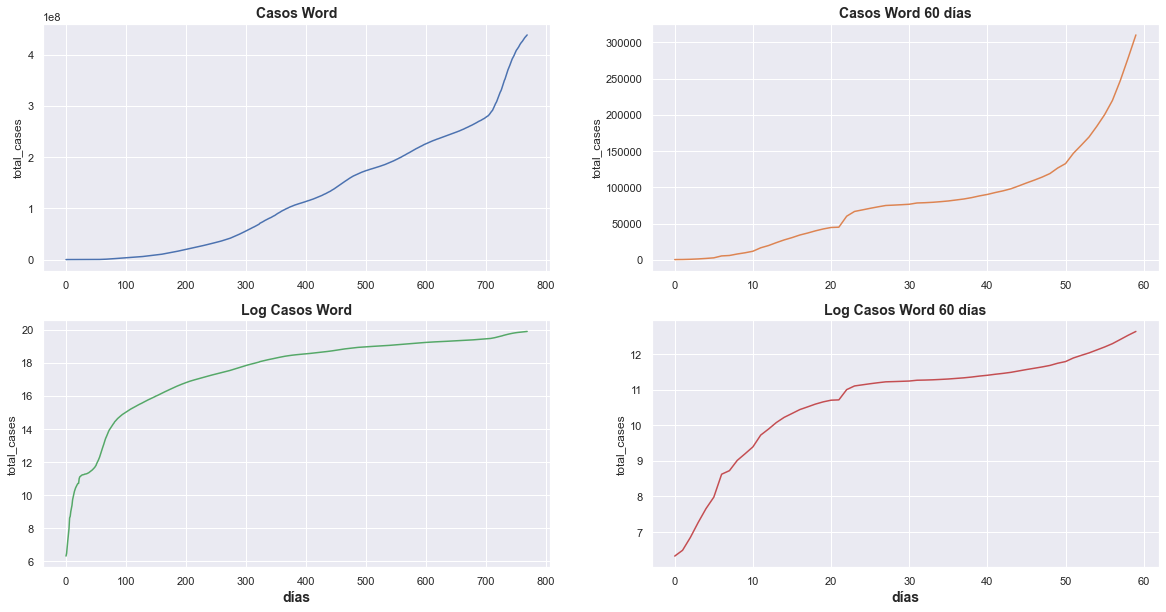

In [21]:
ind_world=np.where(paises=='World')
ind_world=ind_world[0]
casos_world=confirmados[ind_world]
dias=np.arange(0,len(casos_world))

df = datos[datos.location == 'World']
l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
casos_principio=casos_world[l_i:l_i+60]
dias_principio=dias[l_i:l_i+60]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axes = axes.flat

sns.lineplot(x=dias, y=casos_world,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
        ax = axes[0],
        alpha   = 1.0)
axes[0].set_title('Casos Word', fontsize = 14, fontweight = "bold")

sns.lineplot(x=dias_principio, y=casos_principio,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[1]["color"],
        ax = axes[1],
        alpha   = 1.0)
axes[1].set_title('Casos Word 60 días', fontsize = 14, fontweight = "bold")
sns.lineplot(x=dias, y=np.log(casos_world),
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[2]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[2])
axes[2].set_title('Log Casos Word', fontsize = 14, fontweight = "bold")

sns.lineplot(x=dias_principio, y=np.log(casos_principio),
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[3]["color"],
        #line_kws= {'linewidth': 2},
        alpha   = 1.0, ax = axes[3])
axes[3].set_title('Log Casos Word 60 días', fontsize = 14, fontweight = "bold")
axes[2].set_xlabel('días', fontsize = 14, fontweight = "bold")
axes[3].set_xlabel('días', fontsize = 14, fontweight = "bold")

Text(0.5, 0, 'días')

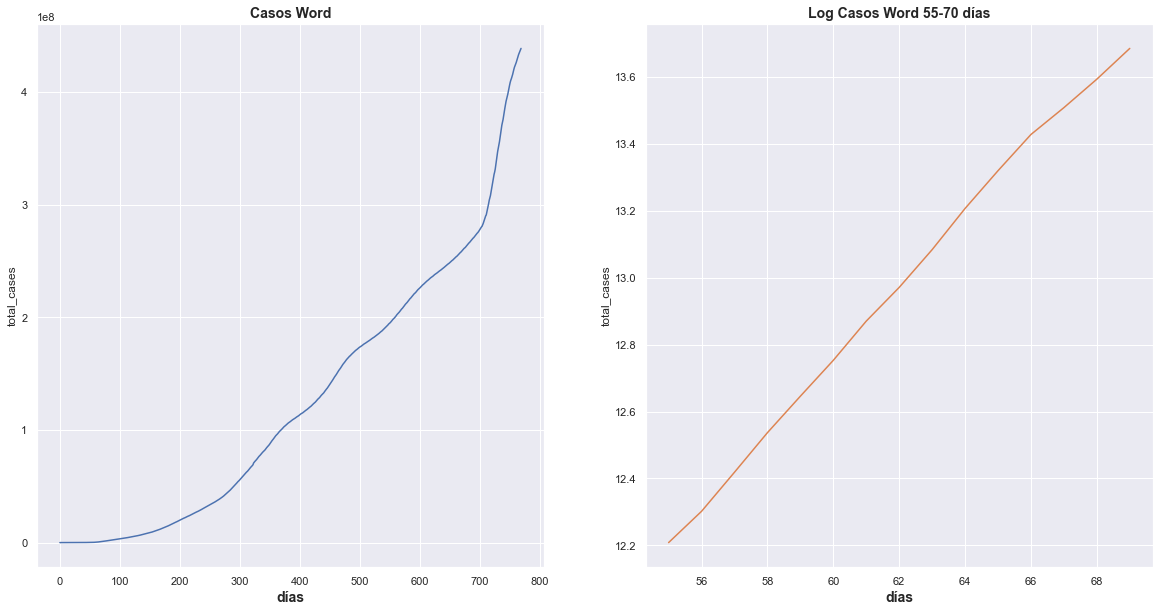

In [22]:
df = datos[datos.location == 'World']
l_i=df.total_cases.isnull().idxmin()-df.iloc[0].name
casos_principio=casos_world[55:70]
dias_principio=dias[55:70]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes = axes.flat
sns.lineplot(x=dias, y=casos_world,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
        ax = axes[0],
        alpha   = 1.0)
axes[0].set_title('Casos Word', fontsize = 14, fontweight = "bold")

sns.lineplot(x=dias_principio, y=np.log(casos_principio),
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[1]["color"],
        ax = axes[1],
        alpha   = 1.0)
axes[1].set_title('Log Casos Word 55-70 días', fontsize = 14, fontweight = "bold")
axes[0].set_xlabel('días', fontsize = 14, fontweight = "bold")
axes[1].set_xlabel('días', fontsize = 14, fontweight = "bold")

In [23]:
casos_principio=casos_world[0:70]
dias_principio=dias[0:70]
    
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
k_world = popt[0]
t0_world = popt[1]
print(k_world, t0_world)

0.09093508452667731 -81.18221169189633


Text(0.5, 0, 'días')

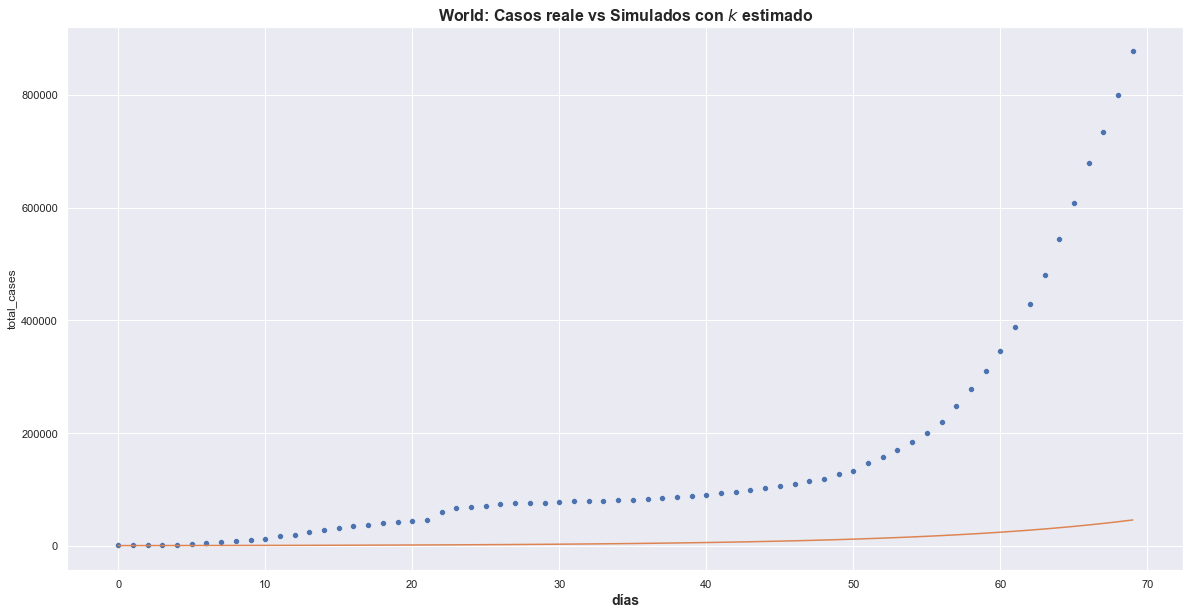

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
plt.title('World: Casos reale vs Simulados con $k$ estimado', fontsize = 16, fontweight = "bold")
casos_simu=exponencial(dias_principio,df_parametros.iloc[:12]['k´s'].mean(),t0_world)
sns.scatterplot(x=dias_principio, y=casos_principio,
    color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
    #line_kws= {'linewidth': 2},
    alpha   = 1.0)
sns.lineplot(x=dias_principio, y=casos_simu,
    color   = (list(plt.rcParams['axes.prop_cycle'])*2)[1]["color"],
    #line_kws= {'linewidth': 2},
    alpha   = 1.0)
plt.xlabel('días', fontsize = 14, fontweight = "bold")

El $k$ promedio de los paises seleccionados ( $k = 0,071461$), no es el más adecuado para hacer inferencias sobre la población mundial como lo muestra la gráfica. Algunas de las razones pueden ser:
 * La cantidad de paises seleccionados no es una muestra representativa;
 * los paises seleccionados no recopilan el comportamiento general;
 * La ventana de tiempo analizada, aún no evidenciaba la tendencia del comportamiento poblacional;
 * Quedaron por fuera paises que tienen un impacto imporante en el comportamiento poblacional.

### e. Gráficos

In [25]:
df_world = datos[datos.location == 'World']
df_world = df_world.loc[:,['date','new_cases', 'new_deaths']]
df_world

,date,new_cases,new_deaths
162521,2020-01-22,0.0,0.0
162522,2020-01-23,98.0,1.0
162523,2020-01-24,286.0,8.0
162524,2020-01-25,493.0,16.0
162525,2020-01-26,684.0,14.0
...,...,...,...
163286,2022-02-25,1592363.0,9118.0
163287,2022-02-26,1329595.0,6422.0
163288,2022-02-27,1066130.0,4426.0
163289,2022-02-28,1403459.0,7762.0


Text(0.5, 0, 'días')

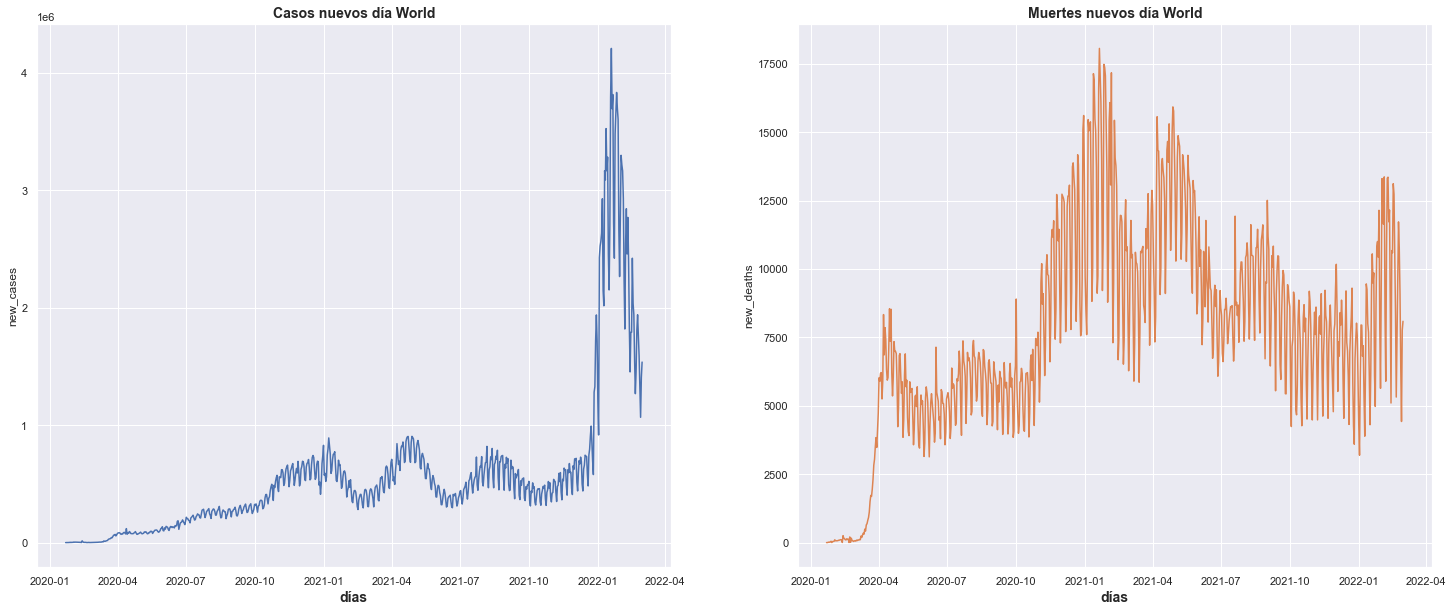

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
axes = axes.flat
sns.lineplot(x="date", y="new_cases",
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
        ax = axes[0],
        alpha   = 1.0, data=df_world)
axes[0].set_title('Casos nuevos día World', fontsize = 14, fontweight = "bold")
axes[0].set_xlabel('días', fontsize = 14, fontweight = "bold")
sns.lineplot(x="date", y="new_deaths",
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[1]["color"],
        ax = axes[1],
        alpha   = 1.0, data=df_world)
axes[1].set_title('Muertes nuevos día World', fontsize = 14, fontweight = "bold")
axes[1].set_xlabel('días', fontsize = 14, fontweight = "bold")

Las anteriores gráficas evidencian el comportamiento diario de la pandemia, en general(world), en los casos de casos nuevos y muertes

In [27]:
df_world.insert(1,'Year',df_world['date'].dt.year,True)
df_world.insert(2,'Month',df_world['date'].dt.month,True)
df_world.insert(3,'Day',df_world['date'].dt.day,True)

df_world.drop(columns=['date'],inplace=True)

keys = np.arange(1,13)
values = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Ww_mapping = dict(zip(keys, values))
df_world['Month'] = pd.Categorical(df_world.Month.map(Ww_mapping),
                                   categories=values,
                                   ordered=True
                                   ) #-------------------------------------------------------https://www.youtube.com/watch?v=K2vSth7K7Ec&t=191s para gerarquizar una variable

df_world.index = range(len(df_world.index))
df_world

,Year,Month,Day,new_cases,new_deaths
0,2020,Jan,22,0.0,0.0
1,2020,Jan,23,98.0,1.0
2,2020,Jan,24,286.0,8.0
3,2020,Jan,25,493.0,16.0
4,2020,Jan,26,684.0,14.0
...,...,...,...,...,...
765,2022,Feb,25,1592363.0,9118.0
766,2022,Feb,26,1329595.0,6422.0
767,2022,Feb,27,1066130.0,4426.0
768,2022,Feb,28,1403459.0,7762.0


Text(0.5, 0.98, 'Casos y Muertes nuevas')

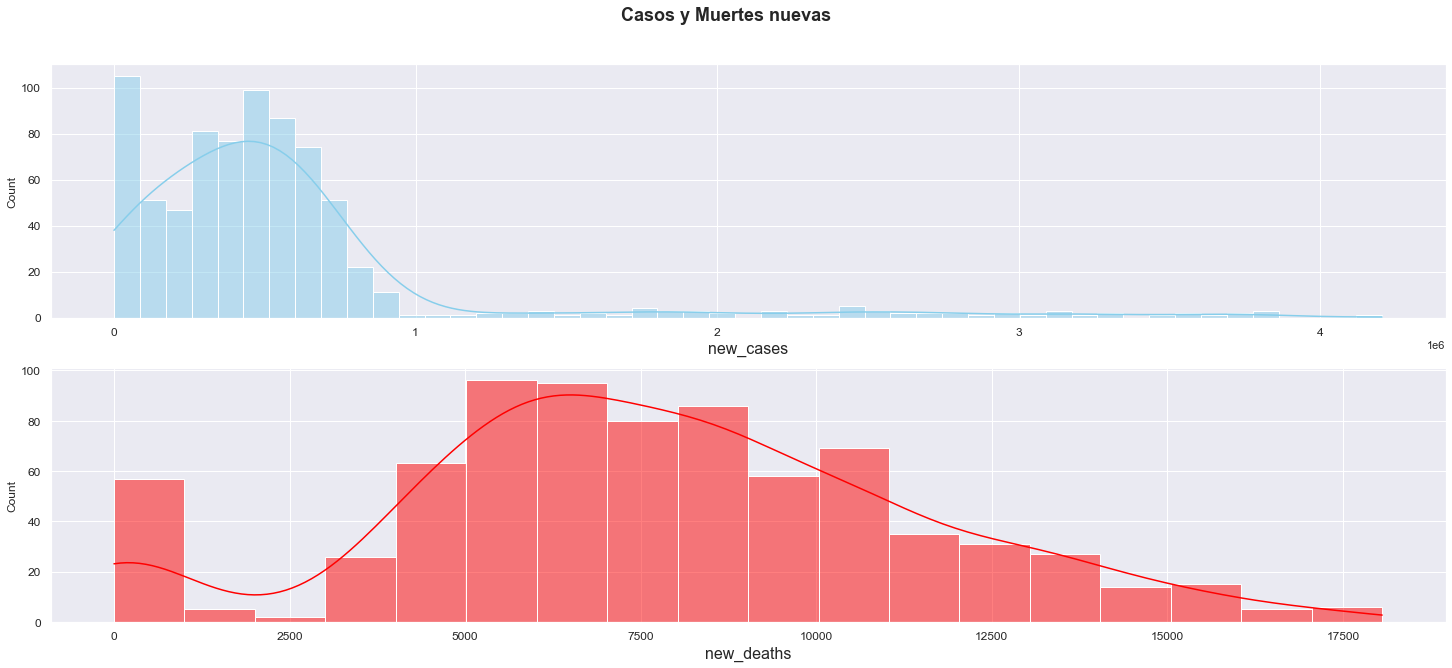

In [28]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25, 10))

sns.histplot(df_world, x="new_cases", color="skyblue", kde=True,ax = axes[0])
axes[0].tick_params(labelsize = 12)
axes[0].set_xlabel('new_cases', fontsize = 16)
sns.histplot(df_world, x="new_deaths", color="red", kde=True, ax = axes[1])
#axes[0].set_title('{p}', fontsize = 14, fontweight = "bold")
axes[1].tick_params(labelsize = 12)
axes[1].set_xlabel('new_deaths', fontsize = 16)
#fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Casos y Muertes nuevas', fontsize = 18, fontweight = "bold")

Evidenciando los inicios exponenciales de la pandemia en número de casos y su principal consecuencia en los dás siguientes, las muertes

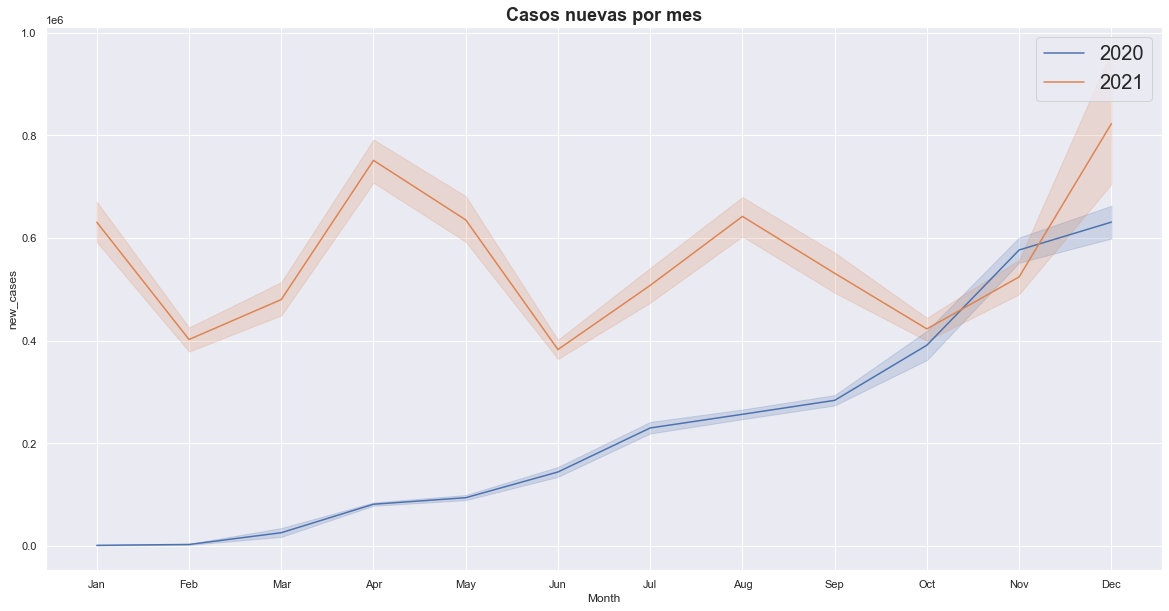

In [29]:
plt.figure(figsize=(20,10))
plt.title('Casos nuevas por mes', fontsize = 18, fontweight = "bold")
sns.lineplot(x="Month", y="new_cases",
             #hue="region",
             #style="event",
             data=df_world[df_world.Year==2020])
sns.lineplot(x="Month", y="new_cases",
             #hue="region",
             #style="event",
             data=df_world[df_world.Year==2021])
plt.legend(labels=["2020","2021"], fontsize = 20)


La evolución de los casos nuevos por mes durante los años 2020 y 2021. Evidenciando en el último trimestre del año 2021 un repunte en los casos nuevos, en parte por la variante omicron

In [30]:
df_world_wide = pd.pivot_table(df_world, values='new_cases', index=['Year'], columns=['Month'], aggfunc=np.sum)
#df_world_wide = df_world.pivot("Year", "Month", "new_cases")
df_world_wide.head()

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2020,9370.0,76104.0,791312.0,2432267.0,2905432.0,4316759.0,7119556.0,7944426.0,8503353.0,12120307.0,17292653.0,19551704.0
2021,19546555.0,11257458.0,14874973.0,22532134.0,19688882.0,11474633.0,15731711.0,19897859.0,15932965.0,13102567.0,15718804.0,25496533.0
2022,89441989.0,58062642.0,1536093.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

### f. Política pública

La política pública elegida corresponde con **la vacunación**. Como será un atributo binario, es decir si el país la "implemento" o no, y teniendo presente que la mayoría de países  la implemento en tiempos diferentes, entonces para impedir un desbalance en las categorías y teniendo presente que su efecto se evidencia en días posteriores, definiremos como implementación de la política (**1**) a aquellos que la iniciaron antes del **28 de diciembre de 2020** y la no implementación (**0**) de la política si esta inició después del **25 de abril de 2021**.

Como indicadores de la política consideraremos:

* **Casos nuevos**: Permite conocer el impacto diario de la pandemia pasados 21 días de aplicada la primera dosis;
* **Casos nuevos por millón de habitantes**: Permite medir el impacto y hacer comparación entre los países;
* **Tasa de reproducción**: Mide el impacto directo de la política de vacunación una vez se aplica.

**Muestra de paises que implementaron la política:**

   * China
   * Rusia
   * United States
   * Denmark
   * Mexico

**Muestra de países que no implementaron la política:**

   * Burkina Faso
   * Central African Republic
   * Haiti
   * Tajikistan
   * Eritrea

In [31]:
# países con inicio de vacunación posterior a mayo de 2021 (países que no implementaron la política)
Paises_novacunados = []
for j,p in enumerate(datos[~datos.location.isin(['International','World','European Union','Europe','Asia','South America','North America'])].location.value_counts().index):
    df = datos[datos.location == p]
    i = df.total_vaccinations.isnull().idxmin()
    if df.loc[i,'date'] >= pd.to_datetime('2021-04-25') or (i-df.iloc[0].name ==0):
        Paises_novacunados.append(p)
        print(p)
print(len(Paises_novacunados))

Vatican
Burkina Faso
Cuba
Central African Republic
Benin
Tanzania
Liberia
Chad
Madagascar
Haiti
Eritrea
Guinea-Bissau
British Virgin Islands
Burundi
Saint Pierre and Miquelon
Yemen
Tajikistan
Marshall Islands
Vanuatu
Samoa
Micronesia (country)
Guernsey
Jersey
Northern Cyprus
Tonga
Sint Maarten (Dutch part)
Kiribati
Nauru
Cook Islands
Palau
Turkmenistan
Tuvalu
Niue
Tokelau
Pitcairn
35


In [32]:
# países con inicio de vacunación antes de febrero de 2021 (países que implementaron la política)
Paises_vacunados = []
for j,p in enumerate(datos[~datos.location.isin(['International','World','European Union','Europe','Asia','South America','North America'])].location.value_counts().index):
    df = datos[datos.location == p]
    i = df.total_vaccinations.isnull().idxmin()
    if df.loc[i,'date'] < pd.to_datetime('2020-12-28') and (i-df.iloc[0].name !=0):
        Paises_vacunados.append(p)
        print(p)
print(len(Paises_vacunados))

Mexico
High income
China
Upper middle income
United States
France
Canada
Germany
Italy
Russia
Slovenia
Denmark
Estonia
Israel
Chile
Bahrain
Switzerland
Norway
Latvia
Romania
Qatar
Lithuania
Czechia
Portugal
Liechtenstein
Costa Rica
Cayman Islands
27


In [33]:
Paises = Paises_novacunados + Paises_vacunados
star = []
delta_new_cases = []
for j,p in enumerate(Paises):
    df = datos[datos.location == p]
    i = df.total_vaccinations.isnull().idxmin()
    if i-df.iloc[0].name ==0:
        star.append(pd.to_datetime('2022-03-01'))
    else:
        star.append(df.loc[i,'date'])
    #print(f'{j+1}. {p}:',df.loc[i,'date'])
    delta_new_cases.append(df.new_cases.isnull().idxmin()-df.iloc[0].name)
df = pd.DataFrame({'País':Paises,'Fecha_inicio': star, 'Delta': delta_new_cases})
df.sort_values('Fecha_inicio',inplace=True)
df.index = range(len(df.index))
df

,País,Fecha_inicio,Delta
0,High income,2020-12-02,0
1,Norway,2020-12-02,1
2,Latvia,2020-12-04,5
3,Denmark,2020-12-08,25
4,United States,2020-12-13,1
...,...,...,...
57,Marshall Islands,2022-03-01,0
58,Saint Pierre and Miquelon,2022-03-01,0
59,Eritrea,2022-03-01,0
60,Pitcairn,2022-03-01,0


In [138]:
# Dataset de países que implementaron o no la política de vacunación
#Paises = Paises_vacunados + Paises_novacunados
df_v = datos[datos.location.isin(Paises)]
df_v.insert(4,'Politica_vacuna',df_v['location'].apply(lambda x: 1 if x in Paises_vacunados else 0),True)
df_v.index = range(len(df_v.index))
df_v

,iso_code,continent,location,date,Politica_vacuna,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,BHR,Asia,Bahrain,2020-02-24,1,1.0,1.0,NaN,NaN,NaN,...,5.8,37.6,NaN,2.0,77.29,0.852,NaN,NaN,NaN,NaN
1,BHR,Asia,Bahrain,2020-02-25,1,23.0,22.0,NaN,NaN,NaN,...,5.8,37.6,NaN,2.0,77.29,0.852,NaN,NaN,NaN,NaN
2,BHR,Asia,Bahrain,2020-02-26,1,33.0,10.0,NaN,NaN,NaN,...,5.8,37.6,NaN,2.0,77.29,0.852,NaN,NaN,NaN,NaN
3,BHR,Asia,Bahrain,2020-02-27,1,33.0,0.0,NaN,NaN,NaN,...,5.8,37.6,NaN,2.0,77.29,0.852,NaN,NaN,NaN,NaN
4,BHR,Asia,Bahrain,2020-02-28,1,36.0,3.0,NaN,NaN,NaN,...,5.8,37.6,NaN,2.0,77.29,0.852,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37556,YEM,Asia,Yemen,2022-02-25,0,11759.0,8.0,4.000,2131.0,1.0,...,7.6,29.2,49.542,0.7,66.12,0.470,NaN,NaN,NaN,NaN
37557,YEM,Asia,Yemen,2022-02-26,0,11760.0,1.0,4.143,2133.0,2.0,...,7.6,29.2,49.542,0.7,66.12,0.470,NaN,NaN,NaN,NaN
37558,YEM,Asia,Yemen,2022-02-27,0,11769.0,9.0,4.714,2134.0,1.0,...,7.6,29.2,49.542,0.7,66.12,0.470,NaN,NaN,NaN,NaN
37559,YEM,Asia,Yemen,2022-02-28,0,11771.0,2.0,4.286,2135.0,1.0,...,7.6,29.2,49.542,0.7,66.12,0.470,NaN,NaN,NaN,NaN


In [139]:
df_v = df_v[[#'continent',
             'location',
             'date',
             'Politica_vacuna',
             #'total_cases',
             'new_cases',
             #'total_deaths',
             #'new_deaths',
             'total_cases_per_million',
             'new_cases_per_million',
             #'total_deaths_per_million',
             #'new_deaths_per_million',
             'reproduction_rate',
             #'hosp_patients',
             #'hosp_patients_per_million',
             #'total_vaccinations'
             ]]
df_v

,location,date,Politica_vacuna,new_cases,total_cases_per_million,new_cases_per_million,reproduction_rate
0,Bahrain,2020-02-24,1,1.0,0.572,0.572,NaN
1,Bahrain,2020-02-25,1,22.0,13.156,12.584,NaN
2,Bahrain,2020-02-26,1,10.0,18.876,5.720,NaN
3,Bahrain,2020-02-27,1,0.0,18.876,0.000,NaN
4,Bahrain,2020-02-28,1,3.0,20.591,1.716,NaN
...,...,...,...,...,...,...,...
37556,Yemen,2022-02-25,0,8.0,385.659,0.262,0.56
37557,Yemen,2022-02-26,0,1.0,385.692,0.033,0.56
37558,Yemen,2022-02-27,0,9.0,385.987,0.295,NaN
37559,Yemen,2022-02-28,0,2.0,386.053,0.066,NaN


In [140]:
## Eliminamos los Nan de la columna new_cases, los desfases en el inicio de la pandemia para cada país
#paises_muestra = muestra_paises_vacunados + muestra_paises_novacunados
#df_v_muestra = df_v[df_v.location.isin(paises_muestra)]
df_1 = pd.DataFrame()
for p in Paises:
    df = df_v[df_v.location == p]
    df_1 = df_1.append(df.drop(range(df.iloc[0].name, df.new_cases.isnull().idxmin(), 1),axis=0))

## Eliminamos los Nan
df_v = df_1.dropna()
df_v

,location,date,Politica_vacuna,new_cases,total_cases_per_million,new_cases_per_million,reproduction_rate
2172,Burkina Faso,2020-03-25,0,32.0,6.792,1.489,1.12
2173,Burkina Faso,2020-03-26,0,6.0,7.071,0.279,1.11
2174,Burkina Faso,2020-03-27,0,28.0,8.373,1.303,1.10
2175,Burkina Faso,2020-03-28,0,27.0,9.629,1.256,1.09
2176,Burkina Faso,2020-03-29,0,15.0,10.327,0.698,1.07
...,...,...,...,...,...,...,...
9006,Costa Rica,2022-02-22,1,3391.0,154471.067,659.849,0.89
9007,Costa Rica,2022-02-23,1,3195.0,155092.777,621.710,0.89
9008,Costa Rica,2022-02-24,1,2796.0,155636.846,544.069,0.89
9009,Costa Rica,2022-02-25,1,2646.0,156151.727,514.881,0.88


In [141]:
muestra_paises_vacunados = ['China',
                    'Russia',
                    'United States',
                    'Denmark',
                    'Mexico']
muestra_paises_novacunados = ['Burkina Faso',
                      #'Central African Republic',
                      'Haiti',
                      #'Tajikistan',
                      'Benin',
                      #'Yemen',
                      #'Cuba',
                      'Chad',
                      #'Tanzania',
                      'Eritrea']

In [142]:
## Eliminamos los Nan de la columna new_cases, los desfases en el inicio de la pandemia para cada país
paises_muestra = muestra_paises_vacunados + muestra_paises_novacunados
df_v_muestra = df_v[df_v.location.isin(paises_muestra)]
#df_1 = pd.DataFrame()
#for p in paises_muestra:
#    df = df_v_muestra[df_v_muestra.location == p]
#    df_1 = df_1.append(df.drop(range(df.iloc[0].name, df.new_cases.isnull().idxmin(), 1),axis=0))

#df_v_muestra = df_1
df_v_muestra

,location,date,Politica_vacuna,new_cases,total_cases_per_million,new_cases_per_million,reproduction_rate
2172,Burkina Faso,2020-03-25,0,32.0,6.792,1.489,1.12
2173,Burkina Faso,2020-03-26,0,6.0,7.071,0.279,1.11
2174,Burkina Faso,2020-03-27,0,28.0,8.373,1.303,1.10
2175,Burkina Faso,2020-03-28,0,27.0,9.629,1.256,1.09
2176,Burkina Faso,2020-03-29,0,15.0,10.327,0.698,1.07
...,...,...,...,...,...,...,...
11216,Denmark,2022-02-22,1,30480.0,453686.046,5243.148,0.78
11217,Denmark,2022-02-23,1,29040.0,458681.486,4995.440,0.76
11218,Denmark,2022-02-24,1,25209.0,463017.920,4336.434,0.75
11219,Denmark,2022-02-25,1,22784.0,466937.207,3919.287,0.75


In [143]:
df_v_muestra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6936 entries, 2172 to 11220
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   location                 6936 non-null   object        
 1   date                     6936 non-null   datetime64[ns]
 2   Politica_vacuna          6936 non-null   int64         
 3   new_cases                6936 non-null   float64       
 4   total_cases_per_million  6936 non-null   float64       
 5   new_cases_per_million    6936 non-null   float64       
 6   reproduction_rate        6936 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 433.5+ KB


In [119]:
## Eliminamos los Nan
df_v_muestra.dropna(inplace=True)

Text(0.5, 0.98, 'log cantidad de casos primeros 60 días')

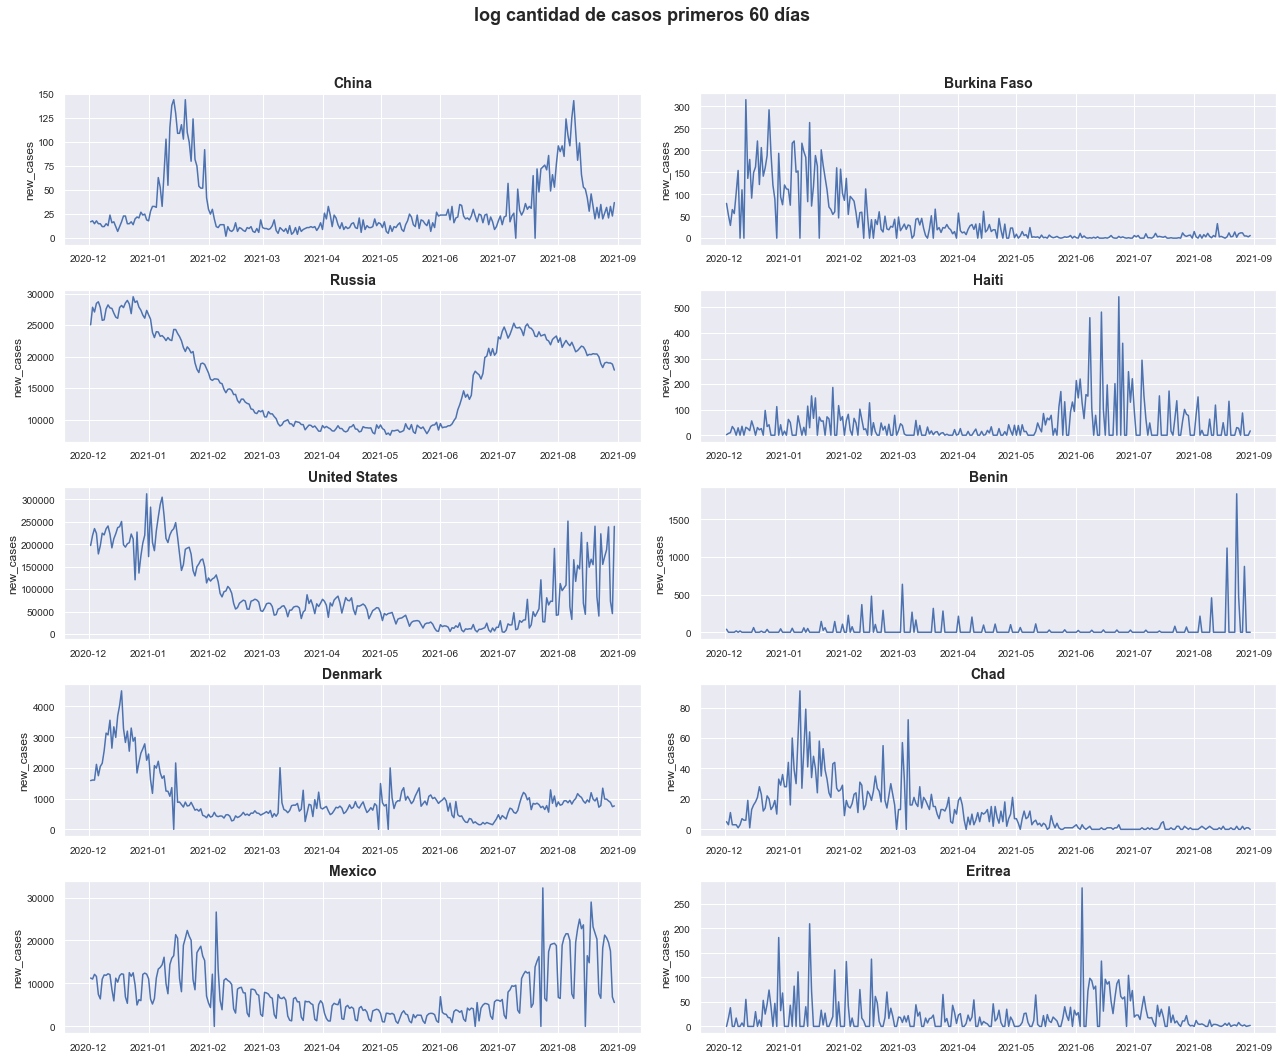

In [123]:
mask_location = df_v_muestra.location
mask_date = df_v_muestra.date
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 15))
axes = axes.flat

for j,p in enumerate(paises_muestra):
    if p in muestra_paises_vacunados:
        j= 2*j
        sns.lineplot(x="date", y="new_cases",
            color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
            ax = axes[j],
            alpha   = 1.0, data=df_v_muestra[(df_v_muestra.location == p) & (df_v_muestra.date > '2020-12-01') & (df_v_muestra.date < '2021-08-31')])
        axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
        axes[j].tick_params(labelsize = 10)
        axes[j].tick_params(labelsize = 10)
        axes[j].set_xlabel("")
    else:
        j= (2*j+1)%10
        sns.lineplot(x="date", y="new_cases",
            color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
            ax = axes[j],
            alpha   = 1.0, data=df_v_muestra[(mask_location == p) & (mask_date > '2020-12-01') & (mask_date < '2021-08-31')])
        axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
        axes[j].tick_params(labelsize = 10)
        axes[j].tick_params(labelsize = 10)
        axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('log cantidad de casos primeros 60 días', fontsize = 18, fontweight = "bold")

Text(0.5, 0.98, 'log cantidad de casos primeros 60 días')

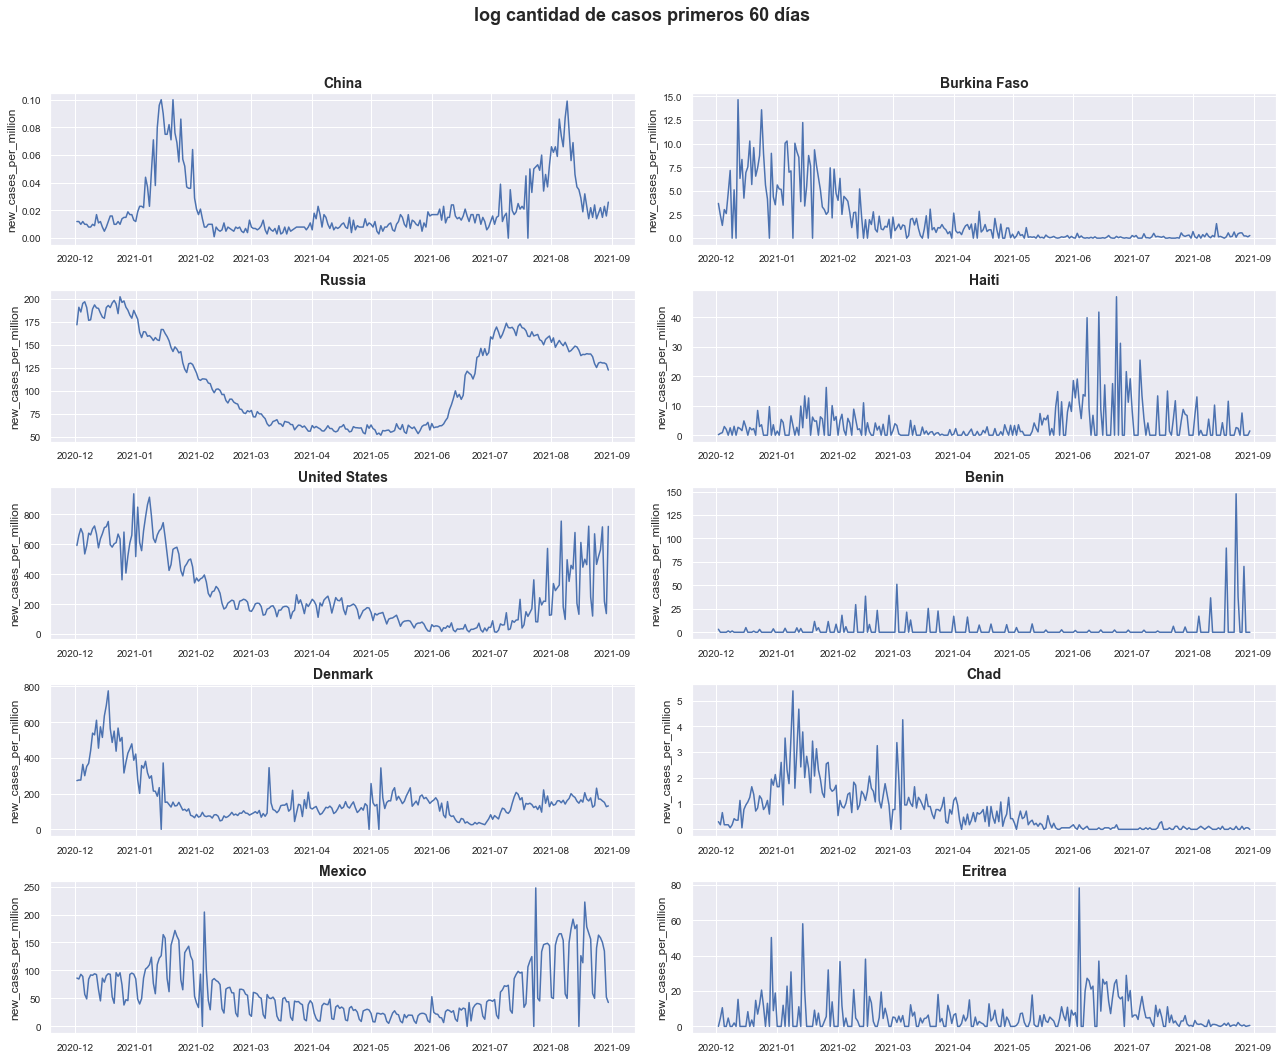

In [120]:
mask_location = df_v_muestra.location
mask_date = df_v_muestra.date
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 15))
axes = axes.flat

for j,p in enumerate(paises_muestra):
    if p in muestra_paises_vacunados:
        j= 2*j
        sns.lineplot(x="date", y="new_cases_per_million",
            color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
            ax = axes[j],
            alpha   = 1.0, data=df_v_muestra[(df_v_muestra.location == p) & (df_v_muestra.date > '2020-12-01') & (df_v_muestra.date < '2021-08-31')])
        axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
        axes[j].tick_params(labelsize = 10)
        axes[j].tick_params(labelsize = 10)
        axes[j].set_xlabel("")
    else:
        j= (2*j+1)%10
        sns.lineplot(x="date", y="new_cases_per_million",
            color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
            ax = axes[j],
            alpha   = 1.0, data=df_v_muestra[(mask_location == p) & (mask_date > '2020-12-01') & (mask_date < '2021-08-31')])
        axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
        axes[j].tick_params(labelsize = 10)
        axes[j].tick_params(labelsize = 10)
        axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('log cantidad de casos primeros 60 días', fontsize = 18, fontweight = "bold")

Text(0.5, 0.98, 'log cantidad de casos primeros 60 días')

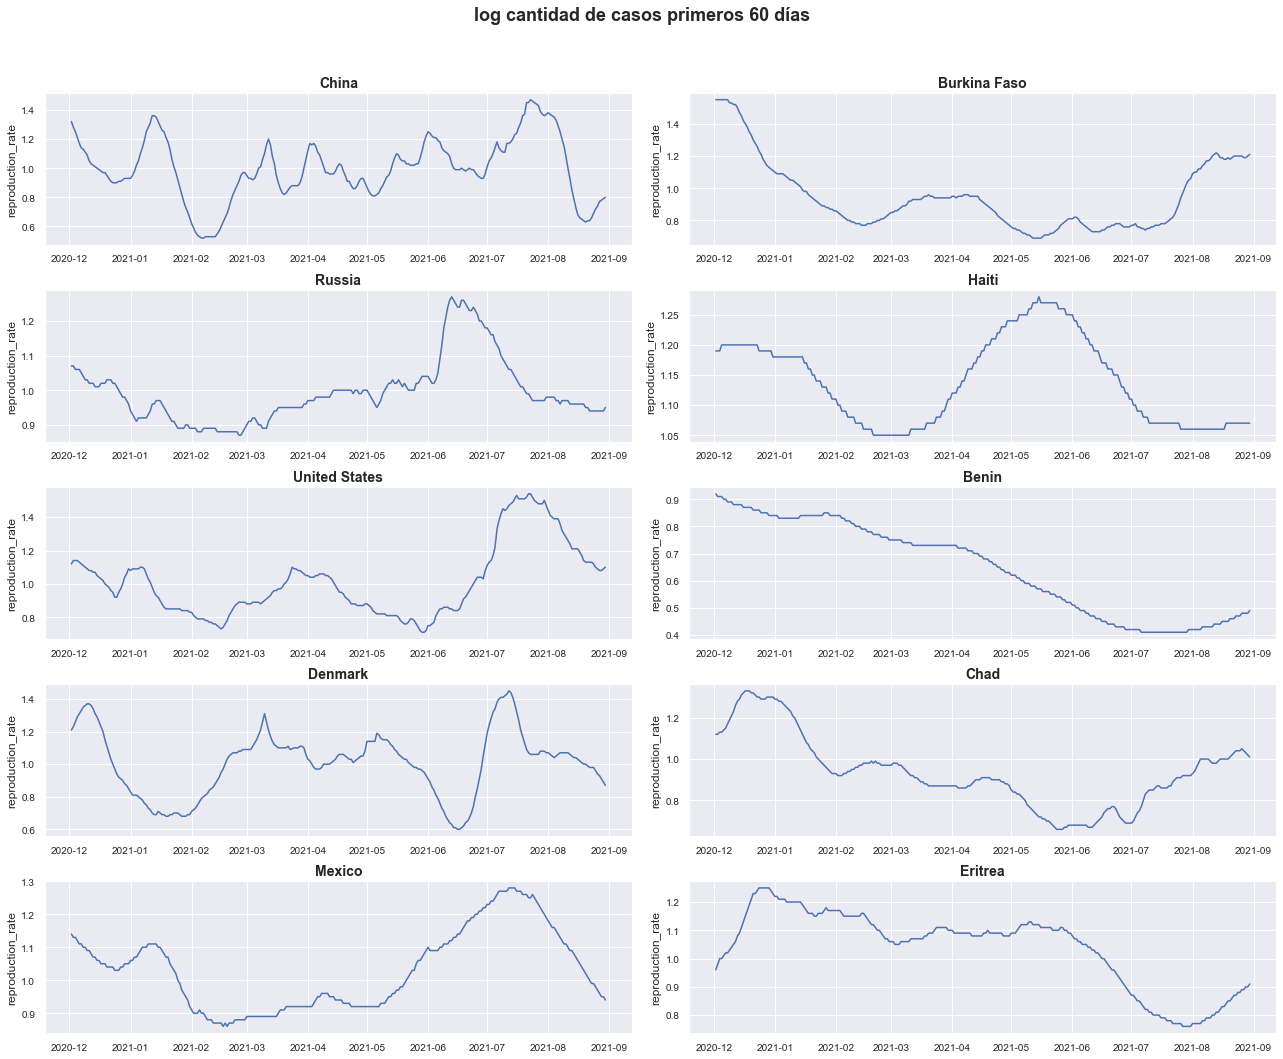

In [122]:
mask_location = df_v_muestra.location
mask_date = df_v_muestra.date
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 15))
axes = axes.flat

for j,p in enumerate(paises_muestra):
    if p in muestra_paises_vacunados:
        j= 2*j
        sns.lineplot(x="date", y="reproduction_rate",
            color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
            ax = axes[j],
            alpha   = 1.0, data=df_v_muestra[(df_v_muestra.location == p) & (df_v_muestra.date > '2020-12-01') & (df_v_muestra.date < '2021-08-31')])
        axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
        axes[j].tick_params(labelsize = 10)
        axes[j].tick_params(labelsize = 10)
        axes[j].set_xlabel("")
    else:
        j= (2*j+1)%10
        sns.lineplot(x="date", y="reproduction_rate",
            color   = (list(plt.rcParams['axes.prop_cycle'])*2)[0]["color"],
            ax = axes[j],
            alpha   = 1.0, data=df_v_muestra[(mask_location == p) & (mask_date > '2020-12-01') & (mask_date < '2021-08-31')])
        axes[j].set_title(f'{p}', fontsize = 14, fontweight = "bold")
        axes[j].tick_params(labelsize = 10)
        axes[j].tick_params(labelsize = 10)
        axes[j].set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('log cantidad de casos primeros 60 días', fontsize = 18, fontweight = "bold")

In [32]:
###############################################################################################################

In [106]:
df_v = df_v[['continent',
             'location',
             'date',
             'Politica_vacuna',
             'total_cases',
             'new_cases',
             'total_deaths',
             'new_deaths',
             'total_cases_per_million',
             'new_cases_per_million',
             'total_deaths_per_million',
             'new_deaths_per_million',
             'reproduction_rate',
             'hosp_patients',
             'hosp_patients_per_million',
             'total_vaccinations'
             ]]
#df_v=df_v.fillna(0)
df_v

,continent,location,date,Politica_vacuna,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,hosp_patients,hosp_patients_per_million,total_vaccinations
0,Asia,Bahrain,2020-02-24,1,1.0,1.0,NaN,NaN,0.572,0.572,NaN,NaN,NaN,NaN,NaN,NaN
1,Asia,Bahrain,2020-02-25,1,23.0,22.0,NaN,NaN,13.156,12.584,NaN,NaN,NaN,NaN,NaN,NaN
2,Asia,Bahrain,2020-02-26,1,33.0,10.0,NaN,NaN,18.876,5.720,NaN,NaN,NaN,NaN,NaN,NaN
3,Asia,Bahrain,2020-02-27,1,33.0,0.0,NaN,NaN,18.876,0.000,NaN,NaN,NaN,NaN,NaN,NaN
4,Asia,Bahrain,2020-02-28,1,36.0,3.0,NaN,NaN,20.591,1.716,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37556,Asia,Yemen,2022-02-25,0,11759.0,8.0,2131.0,1.0,385.659,0.262,69.890,0.033,0.56,NaN,NaN,NaN
37557,Asia,Yemen,2022-02-26,0,11760.0,1.0,2133.0,2.0,385.692,0.033,69.956,0.066,0.56,NaN,NaN,NaN
37558,Asia,Yemen,2022-02-27,0,11769.0,9.0,2134.0,1.0,385.987,0.295,69.989,0.033,NaN,NaN,NaN,NaN
37559,Asia,Yemen,2022-02-28,0,11771.0,2.0,2135.0,1.0,386.053,0.066,70.021,0.033,NaN,NaN,NaN,NaN


In [110]:
#i=97736
c=0
I = []
columna1 = 'total_cases'
columna2 = 'new_cases'
for i in df_v.index[1:]:
    if df_v.loc[i-1,columna1] == df_v.loc[i-1,columna1] and df_v.loc[i,columna1] == df_v.loc[i,columna1] and df_v.loc[i,columna2] != df_v.loc[i,columna2]:
        if df_v.loc[i-1,columna1] > df_v.loc[i,columna1]:
            df_v.loc[i,columna2] = 0
        else:
            df_v.loc[i,columna2] = df_v.loc[i,columna1] - df_v.loc[i-1,columna1]
            I.append(i)
            c=c+1
    else:
        continue
df_v

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,continent,location,date,Politica_vacuna,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,hosp_patients,hosp_patients_per_million,total_vaccinations
0,Asia,Bahrain,2020-02-24,1,1.0,1.0,NaN,NaN,0.572,0.572,NaN,NaN,NaN,NaN,NaN,NaN
1,Asia,Bahrain,2020-02-25,1,23.0,22.0,NaN,NaN,13.156,12.584,NaN,NaN,NaN,NaN,NaN,NaN
2,Asia,Bahrain,2020-02-26,1,33.0,10.0,NaN,NaN,18.876,5.720,NaN,NaN,NaN,NaN,NaN,NaN
3,Asia,Bahrain,2020-02-27,1,33.0,0.0,NaN,NaN,18.876,0.000,NaN,NaN,NaN,NaN,NaN,NaN
4,Asia,Bahrain,2020-02-28,1,36.0,3.0,NaN,NaN,20.591,1.716,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37556,Asia,Yemen,2022-02-25,0,11759.0,8.0,2131.0,1.0,385.659,0.262,69.890,0.033,0.56,NaN,NaN,NaN
37557,Asia,Yemen,2022-02-26,0,11760.0,1.0,2133.0,2.0,385.692,0.033,69.956,0.066,0.56,NaN,NaN,NaN
37558,Asia,Yemen,2022-02-27,0,11769.0,9.0,2134.0,1.0,385.987,0.295,69.989,0.033,NaN,NaN,NaN,NaN
37559,Asia,Yemen,2022-02-28,0,11771.0,2.0,2135.0,1.0,386.053,0.066,70.021,0.033,NaN,NaN,NaN,NaN


In [115]:
#i=97736
c=0
I = []
columna1 = 'total_deaths'
columna2 = 'new_deaths'
for i in df_v.index[1:]:
    if df_v.loc[i-1,columna1] == df_v.loc[i-1,columna1] and df_v.loc[i,columna2] == df_v.loc[i,columna2] and df_v.loc[i,columna1] != df_v.loc[i,columna1] and df_v.loc[i-1,'location'] == df_v.loc[i,'location']:
        df_v.loc[i,columna1] = df_v.loc[i-1,columna1] - df_v.loc[i,columna2]
        I.append(i)
        c=c+1
    else:
        continue
df_v

,continent,location,date,Politica_vacuna,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,hosp_patients,hosp_patients_per_million,total_vaccinations
0,Asia,Bahrain,2020-02-24,1,1.0,1.0,NaN,NaN,0.572,0.572,NaN,NaN,NaN,NaN,NaN,NaN
1,Asia,Bahrain,2020-02-25,1,23.0,22.0,NaN,NaN,13.156,12.584,NaN,NaN,NaN,NaN,NaN,NaN
2,Asia,Bahrain,2020-02-26,1,33.0,10.0,NaN,NaN,18.876,5.720,NaN,NaN,NaN,NaN,NaN,NaN
3,Asia,Bahrain,2020-02-27,1,33.0,0.0,NaN,NaN,18.876,0.000,NaN,NaN,NaN,NaN,NaN,NaN
4,Asia,Bahrain,2020-02-28,1,36.0,3.0,NaN,NaN,20.591,1.716,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37556,Asia,Yemen,2022-02-25,0,11759.0,8.0,2131.0,1.0,385.659,0.262,69.890,0.033,0.56,NaN,NaN,NaN
37557,Asia,Yemen,2022-02-26,0,11760.0,1.0,2133.0,2.0,385.692,0.033,69.956,0.066,0.56,NaN,NaN,NaN
37558,Asia,Yemen,2022-02-27,0,11769.0,9.0,2134.0,1.0,385.987,0.295,69.989,0.033,NaN,NaN,NaN,NaN
37559,Asia,Yemen,2022-02-28,0,11771.0,2.0,2135.0,1.0,386.053,0.066,70.021,0.033,NaN,NaN,NaN,NaN


In [124]:
#i=97736
c=0
I = []
columna1 = 'total_deaths_per_million'
columna2 = 'new_deaths_per_million'
for i in df_v.index[1:]:
    if df_v.loc[i-1,columna1] == df_v.loc[i-1,columna1] and df_v.loc[i,columna2] == df_v.loc[i,columna2] and df_v.loc[i,columna1] != df_v.loc[i,columna1]:
        #df_v.loc[i,columna1] = df_v.loc[i-1,columna1] - df_v.loc[i,columna2]
        I.append(i)
        c=c+1
    else:
        continue
df_v

,continent,location,date,Politica_vacuna,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,hosp_patients,hosp_patients_per_million,total_vaccinations
0,Asia,Bahrain,2020-02-24,1,1.0,1.0,NaN,NaN,0.572,0.572,NaN,NaN,NaN,NaN,NaN,NaN
1,Asia,Bahrain,2020-02-25,1,23.0,22.0,NaN,NaN,13.156,12.584,NaN,NaN,NaN,NaN,NaN,NaN
2,Asia,Bahrain,2020-02-26,1,33.0,10.0,NaN,NaN,18.876,5.720,NaN,NaN,NaN,NaN,NaN,NaN
3,Asia,Bahrain,2020-02-27,1,33.0,0.0,NaN,NaN,18.876,0.000,NaN,NaN,NaN,NaN,NaN,NaN
4,Asia,Bahrain,2020-02-28,1,36.0,3.0,NaN,NaN,20.591,1.716,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37556,Asia,Yemen,2022-02-25,0,11759.0,8.0,2131.0,1.0,385.659,0.262,69.890,0.033,0.56,NaN,NaN,NaN
37557,Asia,Yemen,2022-02-26,0,11760.0,1.0,2133.0,2.0,385.692,0.033,69.956,0.066,0.56,NaN,NaN,NaN
37558,Asia,Yemen,2022-02-27,0,11769.0,9.0,2134.0,1.0,385.987,0.295,69.989,0.033,NaN,NaN,NaN,NaN
37559,Asia,Yemen,2022-02-28,0,11771.0,2.0,2135.0,1.0,386.053,0.066,70.021,0.033,NaN,NaN,NaN,NaN


In [ ]:
###################################################################################################################################

### g. Clasificador

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
#from sklearn.feature_extraction.text import TfidfVectorizer

# Importamos modelos
from sklearn.naive_bayes import GaussianNB

# Metricas
from sklearn.metrics import classification_report # Para un reporte con precision, recall y f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay

In [145]:
def confusion(y_test,y_pred, df,variable):
    names=list(df[variable].value_counts().index)
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(7,7))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

def k_validacion_cruzada(model,x,y,k):
    scores = cross_val_score(model, x, y, cv=k)
    print("%0.4f de precisión con desviación estándar de %0.2f" % (scores.mean(), scores.std()))

In [146]:

X = df_v_muestra.drop(columns=['location','date' ,'Politica_vacuna'])
y = df_v_muestra.Politica_vacuna

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 123
                                                                       )

print('Entrenamiento', X_train.shape)
print('')
print('Testeo', X_test.shape)


Entrenamiento (5548, 4)

Testeo (1388, 4)


In [147]:
nb = GaussianNB()

#nbx_train = tfidf_train.toarray()

nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('Accuracy : ', accuracy_score(y_test,y_pred))

Accuracy :  0.8695965417867435


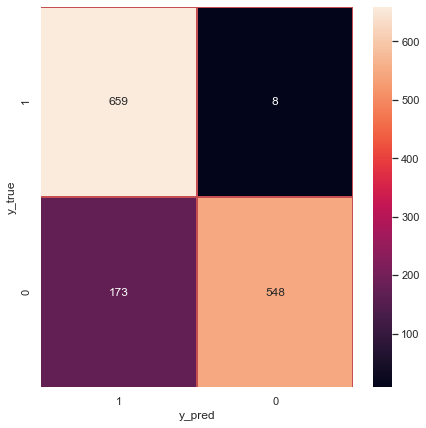

In [154]:
confusion(y_test,y_pred,df_v_muestra,'Politica_vacuna')

In [152]:
X_new = df_v[~df_v.location.isin(paises_muestra)].drop(columns=['location','date' ,'Politica_vacuna'])
y_new = df_v[~df_v.location.isin(paises_muestra)].Politica_vacuna

print('X_new', X_new.shape)
print('')
print('y_new', y_new.shape)

X_new (19515, 4)

y_new (19515,)


In [153]:
y_new_pred = nb.predict(X_new)

print('Accuracy : ', accuracy_score(y_new,y_new_pred))

Accuracy :  0.8622598001537279


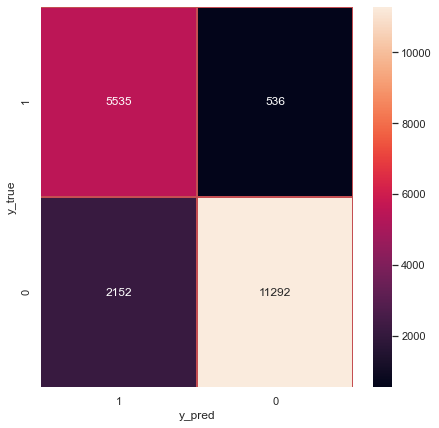

In [155]:
confusion(y_new,y_new_pred,df_v,'Politica_vacuna')

### h. Regresión Logística

In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [157]:
logreg = LogisticRegression()
# parameter grid
parameters = {
    'penalty' : ['l1','l2'],
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [158]:
model = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [159]:
model.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_va

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [160]:
print("Tuned Hyperparameters :", model.best_params_)
print("Accuracy :",model.best_score_)

Tuned Hyperparameters : {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.8749129996422415


In [161]:
logreg = LogisticRegression(**model.best_params_)
logreg.fit(X_train, y_train)

LogisticRegression(C=10.0, solver='newton-cg')

In [162]:
y_test_pred = logreg.predict(X_test)
y_train_pred = logreg.predict(X_train)

In [ ]:
#puntajes(X_test,X_train,y_test, y_test_pred, logreg)

In [163]:
#y_new_pred = nb.predict(X_new)

print('Accuracy : ', accuracy_score(y_test,y_test_pred))

Accuracy :  0.8847262247838616


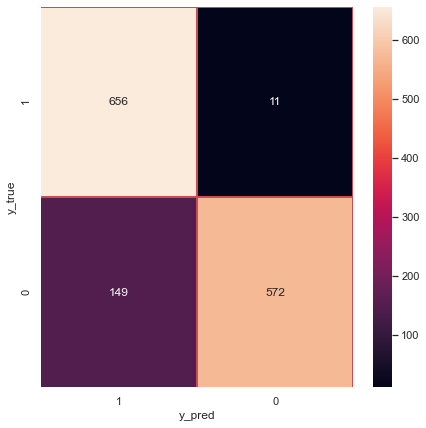

In [164]:
confusion(y_test,y_test_pred,df_v_muestra,'Politica_vacuna')

In [166]:
score_paises = logreg.score(X_test, y_test)
w0 = logreg.intercept_[0]
w = w1, w2, w3, w4 = logreg.coef_[0]

equation = "y = %f + (%f * x1) + (%f * x2) + (%f * x3) + (%f * x4)" % (w0, w1, w2, w3, w4)
print(equation)

model_paises_ec = pd.DataFrame({"Seleccion":"Paises","w0":[w0], "w1":[w1], "w2":[w2], "w3":[w3], "w4":[w4], "Score":[score_paises]})
model_paises_ec

y = -3.518736 + (0.005991 * x1) + (0.000117 * x2) + (-0.022056 * x3) + (2.156500 * x4)


,Seleccion,w0,w1,w2,w3,w4,Score
0,Paises,-3.518736,0.005991,0.000117,-0.022056,2.1565,0.884726


                   feature  importance
3        reproduction_rate    8.640841
0                new_cases    1.006009
1  total_cases_per_million    1.000117
2    new_cases_per_million    0.978185


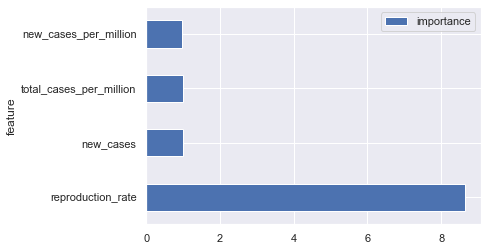

In [169]:
import math

feature_names = ["new_cases", 'total_cases_per_million', "new_cases_per_million","reproduction_rate"]
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
print(feature_importance)
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

In [168]:
list(df_v_muestra.columns)

['location',
 'date',
 'Politica_vacuna',
 'new_cases',
 'total_cases_per_million',
 'new_cases_per_million',
 'reproduction_rate']

# Por paises

## China

Text(0, 0.5, 'log cantidad de casos')

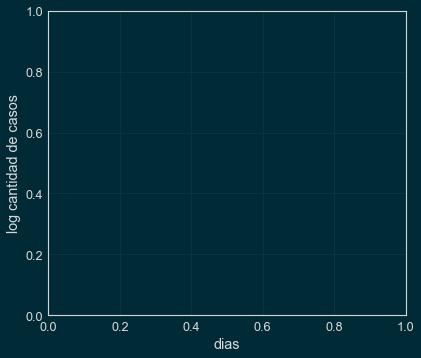

In [44]:

plt.plot,np.log(casos_principio)
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Como última pista, hagamos una función que determine los casos nuevos por día a partir de estas curvas. Puede ser útil para tu análisis.

In [38]:
def casos_nuevos(casos):
    nuevos=np.zeros(len(casos))
    i=0
    while i<len(nuevos)-1:
    nuevos[i]=casos[i+1]-casos[i]
    i=i+1

    return nuevos   

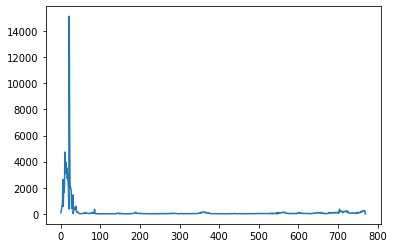

In [39]:
casos_arg=np.array(casos_arg)
nuevos_arg=casos_nuevos(casos_arg)
plt.plot(nuevos_arg)